# Epsilon-Greedy Policy

In _RecoGym_, all previous studies were concentrated on _Exploit_ Selection Policy. This Notebook dedicated to the analysis of the _`Agent`_ behaviour when the _`Agent`_ uses _**both**_ _Exploit_ **and** _Explore_ Selection Policies. Here, the simplest one _Explore_/_Exploit_ Selection Policy is analysed: _Epsilon-Greedy_.


The policy selection algorithm will be approbated for the following _`Agents`_:
* _**`Bandit Count`**_: the _`Agent`_ that counts views of products and provides the most frequently viewed product as an _`Action`_.
* _**`Logistic Regression`**_: the _`Agent`_ that uses _Logistic Regression_ model to predict a click for an _`Action`_.
* _**`Logistic Regression with IPS`**_: the _`Agent`_ that utilises _Inverse Propensity Scores_ in training of _Logistic Regression_ model.

All the previously mentioned _`Agents`_ will be initialised with models trained on the same sample of data (logs).

In this study, you shall find the answers to these questions:
* How _Click-Through Rate_ evolves via using different values of $\varepsilon$ in different models through time?
* How the _Explore_ Policy Selection impacts in overall on the _Revenue_?

Finally,  an _`Agent`_ based on _**`Recoursive Neural Network`**_ will be analysed in _RecoGym_. This time, we will try to answer the question: how a more complex model can handle _RecoGym_  environment when _time_ starts influencing on _Organic_ and _Bandit_ events.

Below you shall find the code that initialises the environment.

In [1]:
import gym, reco_gym
from copy import deepcopy
from reco_gym import env_1_args
import matplotlib.pyplot as plt

%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [8, 4]

ABTestNumberOfUsers = 10000
RandomSeed = 42

NumberOfProducts = 10

EpsilonDelta = .02
EpsilonSteps = 6 # Including epsilon = 0.0.
EpsilonPrecision = 2

InitialTrainingDataSetUsers = 500
EpsilonTrainingDataSetUsers = 500

GraphCTRMin = 0.007
GraphCTRMax = 0.017

EvolutionSteps = 6


env_1_args['random_seed'] = RandomSeed
env_1_args['num_products'] = NumberOfProducts
env_1_args['num_epochs'] = 100
env_1_args['num_epochs'] = 100


env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

Through this notebook, we will work with the _`Agents`_ those are initialized as follows:

In [2]:
from reco_gym import Configuration

from agents import BanditMFSquare, bandit_mf_square_args
from agents import BanditCount, bandit_count_args
from agents import RandomAgent, random_args
from agents import NnIpsAgent, nn_ips_args
from agents import LogregPolyAgent, logreg_poly_args
from agents import EpsilonGreedy, epsilon_greedy_args
from agents import LogregMulticlassIpsAgent, logreg_multiclass_ips_args

agent_banditmfsquare = BanditMFSquare(Configuration({
    **env_1_args,
    **bandit_mf_square_args,
}))

agent_banditcount = BanditCount(Configuration({
    **env_1_args,
    **bandit_count_args,
}))

agent_rand = RandomAgent(Configuration({
    **env_1_args,
    **random_args,
}))

agent_nn_ips = NnIpsAgent(Configuration({
    **env_1_args,
    **nn_ips_args,
}))

agent_logreg_poly = LogregPolyAgent(Configuration({
    **env_1_args,
    **logreg_poly_args,
}))


def history_weight(t):
    return 1/(1 + t)


agent_logreg_poly_history = LogregPolyAgent(Configuration({
    **env_1_args,
    **logreg_poly_args,
    'weight_history_function': history_weight,
}))

agent_logreg_poly_ips = LogregPolyAgent(Configuration({
    **env_1_args,
    **logreg_poly_args,
    'with_ips': True,
}))

agent_logreg_multiclass_ips = LogregMulticlassIpsAgent(Configuration({
    **env_1_args,
    **logreg_multiclass_ips_args,
}))

# A list of Agents used in this Notebook to verify the evolution of CTR.
agents = {
    'LogReg Poly': agent_logreg_poly,
    'LogReg Poly & IPS': agent_logreg_poly_ips,
    'Bandit $MF^2$': agent_banditmfsquare,
    'NN & IPS': agent_nn_ips,
    'LogReg Poly H': agent_logreg_poly_history,
    'Random': agent_rand,   
}

## Advance Models in Time

As we are going to start using _Exploration_ Policy Selection in _`Agents`_, we should decide how models are to be updated/retrained with taking into account the data obtained during _Explorations_. Below you shall find three different approaches used for model retraining.

In [3]:
from reco_gym import TrainingApproach, EvolutionCase, evolute_agent

import numpy as np
import multiprocessing
import time

from enum import Enum
from multiprocessing import Pool
from scipy.stats.distributions import beta

def generate_epsilons(epsilon_step = EpsilonDelta, iterations = EpsilonSteps):
    return [0.00, 0.01, 0.02, 0.03, 0.05, 0.08]


def format_epsilon(epsilon):
    return ("{0:." + f"{EpsilonPrecision}" +"f}").format(round(epsilon, EpsilonPrecision))


def collect_stats(args):
    """
    Function that is executed in a separate process.

    :param args: arguments of the process to be executed.

    :return: a dictionary of success/failures of applying an Agent.
    """
    start = time.time()
    epsilon = args['epsilon']
    epsilon_key = format_epsilon(epsilon)
    epsilon_greedy_agent = EpsilonGreedy(
        Configuration({
            **epsilon_greedy_args,
            **env_1_args,
            'epsilon': epsilon,
        }),
        deepcopy(args['agent'])
    )
    print(f"Start: ε = {epsilon_key}")
    num_evolution_steps = args['num_evolution_steps']
    rewards = reco_gym.evolute_agent(
        deepcopy(args['env']),
        epsilon_greedy_agent,
        args['num_initial_train_users'],
        args['num_step_users'],
        num_evolution_steps,
        args['training_approach']
    )
    
    assert (len(rewards[EvolutionCase.SUCCESS]) == len(rewards[EvolutionCase.FAILURE]))
    assert (len(rewards[EvolutionCase.SUCCESS]) == num_evolution_steps)
    print(f"End: ε = {epsilon_key} ({time.time() - start}s)")

    return {
        epsilon_key: {
            EvolutionCase.SUCCESS: rewards[EvolutionCase.SUCCESS],
            EvolutionCase.SUCCESS_GREEDY: rewards[EvolutionCase.SUCCESS_GREEDY],
            EvolutionCase.FAILURE: rewards[EvolutionCase.FAILURE],
            EvolutionCase.FAILURE_GREEDY: rewards[EvolutionCase.FAILURE_GREEDY],
            EvolutionCase.ACTIONS: rewards[EvolutionCase.ACTIONS]
        }
    }

    return stats


def build_exploration_data(
        env,
        agents,
        training_approach,
        num_initial_train_users = InitialTrainingDataSetUsers,
        num_step_users = EpsilonTrainingDataSetUsers,
        num_evolution_steps = EvolutionSteps
):
    """
    A helper function that collects and draws data regarding Agents evolution
    under different values of epsilon for Epsilon-Greedy Selection Policy.

        :param env: The environment where evolution should be applied;
         every time when a new step of evolution is applied, the environment is deeply copied
         thus the Environment does not interferes with evolution steps.

        :param agents: A dictionary of Agents (Key => an instance of an Agent).

        :param training_approach:  A training approach applied in verification;
         for mode details look at `TrainingApproach' enum.

        :param num_initial_train_users: how many users' data should be used
         to train an initial model BEFORE evolution steps.

        :param num_step_users: how many users' data should be used
         at each evolution step.

        :param num_evolution_steps: how many evolution steps should be applied
         for an Agent with Epsilon-Greedy Selection Policy.

         :param max_agents_per_row: how many graphs should be drawn per a row.

        :return a dictionary of Agent evolution statistics in the form:
            {
                'Agent Name': {
                    'Epsilon Values': {
                        EvolutionCase.SUCCESS: [an array of clicks (for each ith step of evolution)]
                        EvolutionCase.FAILURE: [an array of failure to draw a click (for each ith step of evolution)]
                    }
                }
            }
    """
    epsilons = generate_epsilons()

    # A dictionary that stores all data of Agent evolution statistics.
    # Key is Agent Name, value is statistics.
    agent_evolution_stats = dict()

    for agent_key in agents:
        print(f"Agent: {agent_key}")
        agent_stats = dict()

        with Pool(processes = multiprocessing.cpu_count()) as pool:
            for result in pool.map(
                    collect_stats,
                    [
                        {
                            'epsilon': epsilon,
                            'env': env,
                            'agent': agents[agent_key],
                            'num_initial_train_users': num_initial_train_users,
                            'num_step_users': num_step_users,
                            'num_evolution_steps': num_evolution_steps,
                            'training_approach': training_approach,
                        }
                        for epsilon in epsilons
                    ]
            ):
                agent_stats = {
                    **agent_stats,
                    **result,
                }

        agent_evolution_stats[agent_key] = agent_stats

    return agent_evolution_stats


def plot_evolutions(
    agent_evolution_stats,
    max_agents_per_row = 2
):
    epsilons = generate_epsilons()
    figs, axs = plt.subplots(
        int(len(agents) / max_agents_per_row),
        max_agents_per_row,
        figsize = (16, 10),
        squeeze = False
    )
    labels = [("$\epsilon=$" + format_epsilon(epsilon)) for epsilon in epsilons]

    for (ix, agent_key) in enumerate(agent_evolution_stats):
        ax = axs[int(ix / max_agents_per_row), int(ix % max_agents_per_row)]
        agent_evolution_stat = agent_evolution_stats[agent_key]
        
        ctr_means = []
        for epsilon in epsilons:
            epsilon_key = format_epsilon(epsilon)
            evolution_stat = agent_evolution_stat[epsilon_key]
            
            steps = []
            ms = []
            q0_025 = []
            q0_975 = []
            
            assert(len(evolution_stat[EvolutionCase.SUCCESS]) == len(evolution_stat[EvolutionCase.FAILURE]))
            for step in range(len(evolution_stat[EvolutionCase.SUCCESS])):
                steps.append(step)
                successes = evolution_stat[EvolutionCase.SUCCESS][step]
                failures = evolution_stat[EvolutionCase.FAILURE][step]
            
                ms.append(beta.ppf(0.5, successes + 1, failures + 1))
                q0_025.append(beta.ppf(0.025, successes + 1, failures + 1))
                q0_975.append(beta.ppf(0.975, successes + 1, failures + 1))
            
            ctr_means.append(np.mean(ms))

            ax.fill_between(
                range(len(steps)),
                q0_975,
                q0_025,
                alpha=.05
            )
            ax.plot(steps, ms)
            
        ctr_means_mean = np.mean(ctr_means)
        ctr_means_div = np.sqrt(np.var(ctr_means))
        ax.set_title(
            f"Agent: {agent_key}\n"
            + "$\hat{\mu}^{CTR}_{0.5}="
            + "{0:.5f}".format(round(ctr_means_mean, 5))
            + "$, "
            + "$\hat{\sigma}^{CTR}_{0.5}="
            + "{0:.5f}".format(round(ctr_means_div, 5))
            + "$"
        )
        ax.legend(labels)
        ax.set_ylabel('CTR')
        ax.set_ylim([GraphCTRMin, GraphCTRMax])
        
    plt.subplots_adjust(hspace = .5)
    plt.show()


def plot_heat_actions(
    agent_evolution_stats,
    max_epsilons_per_row = EpsilonSteps
):
    the_first_agent = next(iter(agent_evolution_stats.values()))
    epsilon_steps = len(the_first_agent)
    rows = int(len(agent_evolution_stats) * epsilon_steps / max_epsilons_per_row)
    figs, axs = plt.subplots(
        int(len(agent_evolution_stats) * epsilon_steps / max_epsilons_per_row),
        max_epsilons_per_row,
        figsize = (16, 4 * rows),
        squeeze = False
    )
    
    for (ix, agent_key) in enumerate(agent_evolution_stats):
        agent_evolution_stat = agent_evolution_stats[agent_key]
        for (jx, epsilon_key) in enumerate(agent_evolution_stat):
            flat_index = ix * epsilon_steps + jx
            ax = axs[int(flat_index / max_epsilons_per_row), int(flat_index % max_epsilons_per_row)]
    
            evolution_stat = agent_evolution_stat[epsilon_key]
            
            action_stats = evolution_stat[EvolutionCase.ACTIONS]
            total_actions = len(action_stats)
            heat_data = []
            for kx in range(total_actions):
                heat_data.append(action_stats[kx])

            heat_data = np.array(heat_data)
            im = ax.imshow(heat_data)

            ax.set_yticks(np.arange(total_actions))
            ax.set_yticklabels([f"{action_id}" for action_id in range(total_actions)])

            ax.set_title(f"Agent: {agent_key}\n$\epsilon=${epsilon_key}")

            cbar = ax.figure.colorbar(im, ax=ax)

    plt.show()

### Model Retraining: All Data

In this case, all samples obtained during _*both*_ _Exploration_ **and** _Explotation_ are used to retrain a _Model_.

**Note:** the training data used for the very first training of the Model are used as well.

In [4]:
stats_all_data = build_exploration_data(env, agents, TrainingApproach.ALL_DATA)

Agent: LogReg Poly
Start: ε = 0.00
Start: ε = 0.01
Start: ε = 0.02
Start: ε = 0.05
Start: ε = 0.08
Start: ε = 0.03
End: ε = 0.00 (2565.9938657283783s)
End: ε = 0.05 (2862.6728117465973s)
End: ε = 0.01 (2872.216371536255s)
End: ε = 0.03 (2876.1592428684235s)
End: ε = 0.02 (2893.0461785793304s)
End: ε = 0.08 (2906.025616168976s)
Agent: LogReg Poly & IPS
Start: ε = 0.02
Start: ε = 0.01
Start: ε = 0.03
Start: ε = 0.08
Start: ε = 0.00
Start: ε = 0.05
End: ε = 0.00 (643.8680894374847s)
End: ε = 0.02 (647.8062331676483s)
End: ε = 0.05 (672.2207238674164s)
End: ε = 0.01 (678.9422273635864s)
End: ε = 0.03 (687.9257979393005s)
End: ε = 0.08 (695.5072004795074s)
Agent: Bandit $MF^2$
Start: ε = 0.01
Start: ε = 0.02
Start: ε = 0.00
Start: ε = 0.03
Start: ε = 0.08
Start: ε = 0.05
End: ε = 0.00 (240.5804579257965s)
End: ε = 0.01 (242.4998710155487s)
End: ε = 0.03 (244.60724568367004s)
End: ε = 0.02 (245.4347116947174s)
End: ε = 0.05 (247.008957862854s)
End: ε = 0.08 (247.8445839881897s)
Agent: NN & I

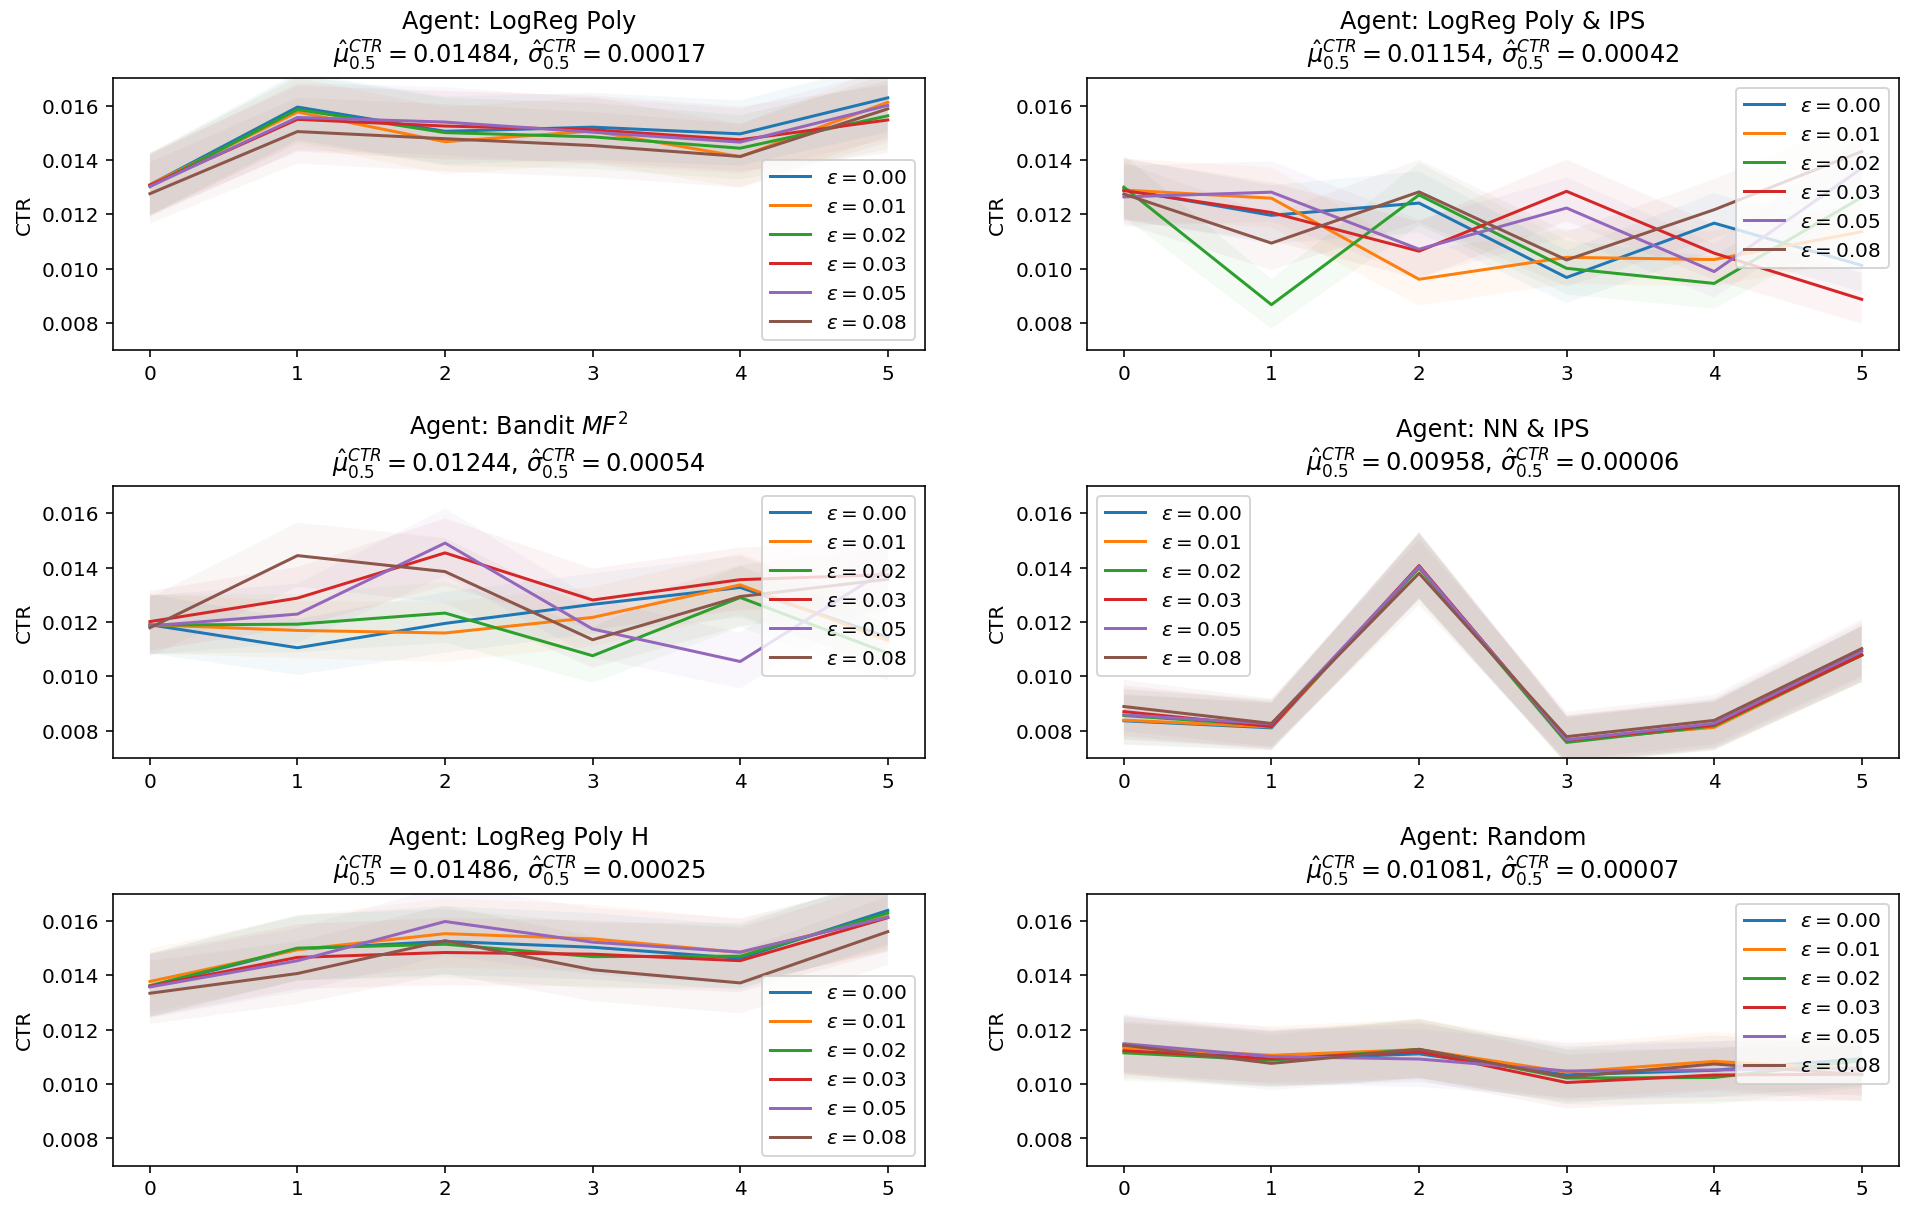

In [5]:
plot_evolutions(stats_all_data)

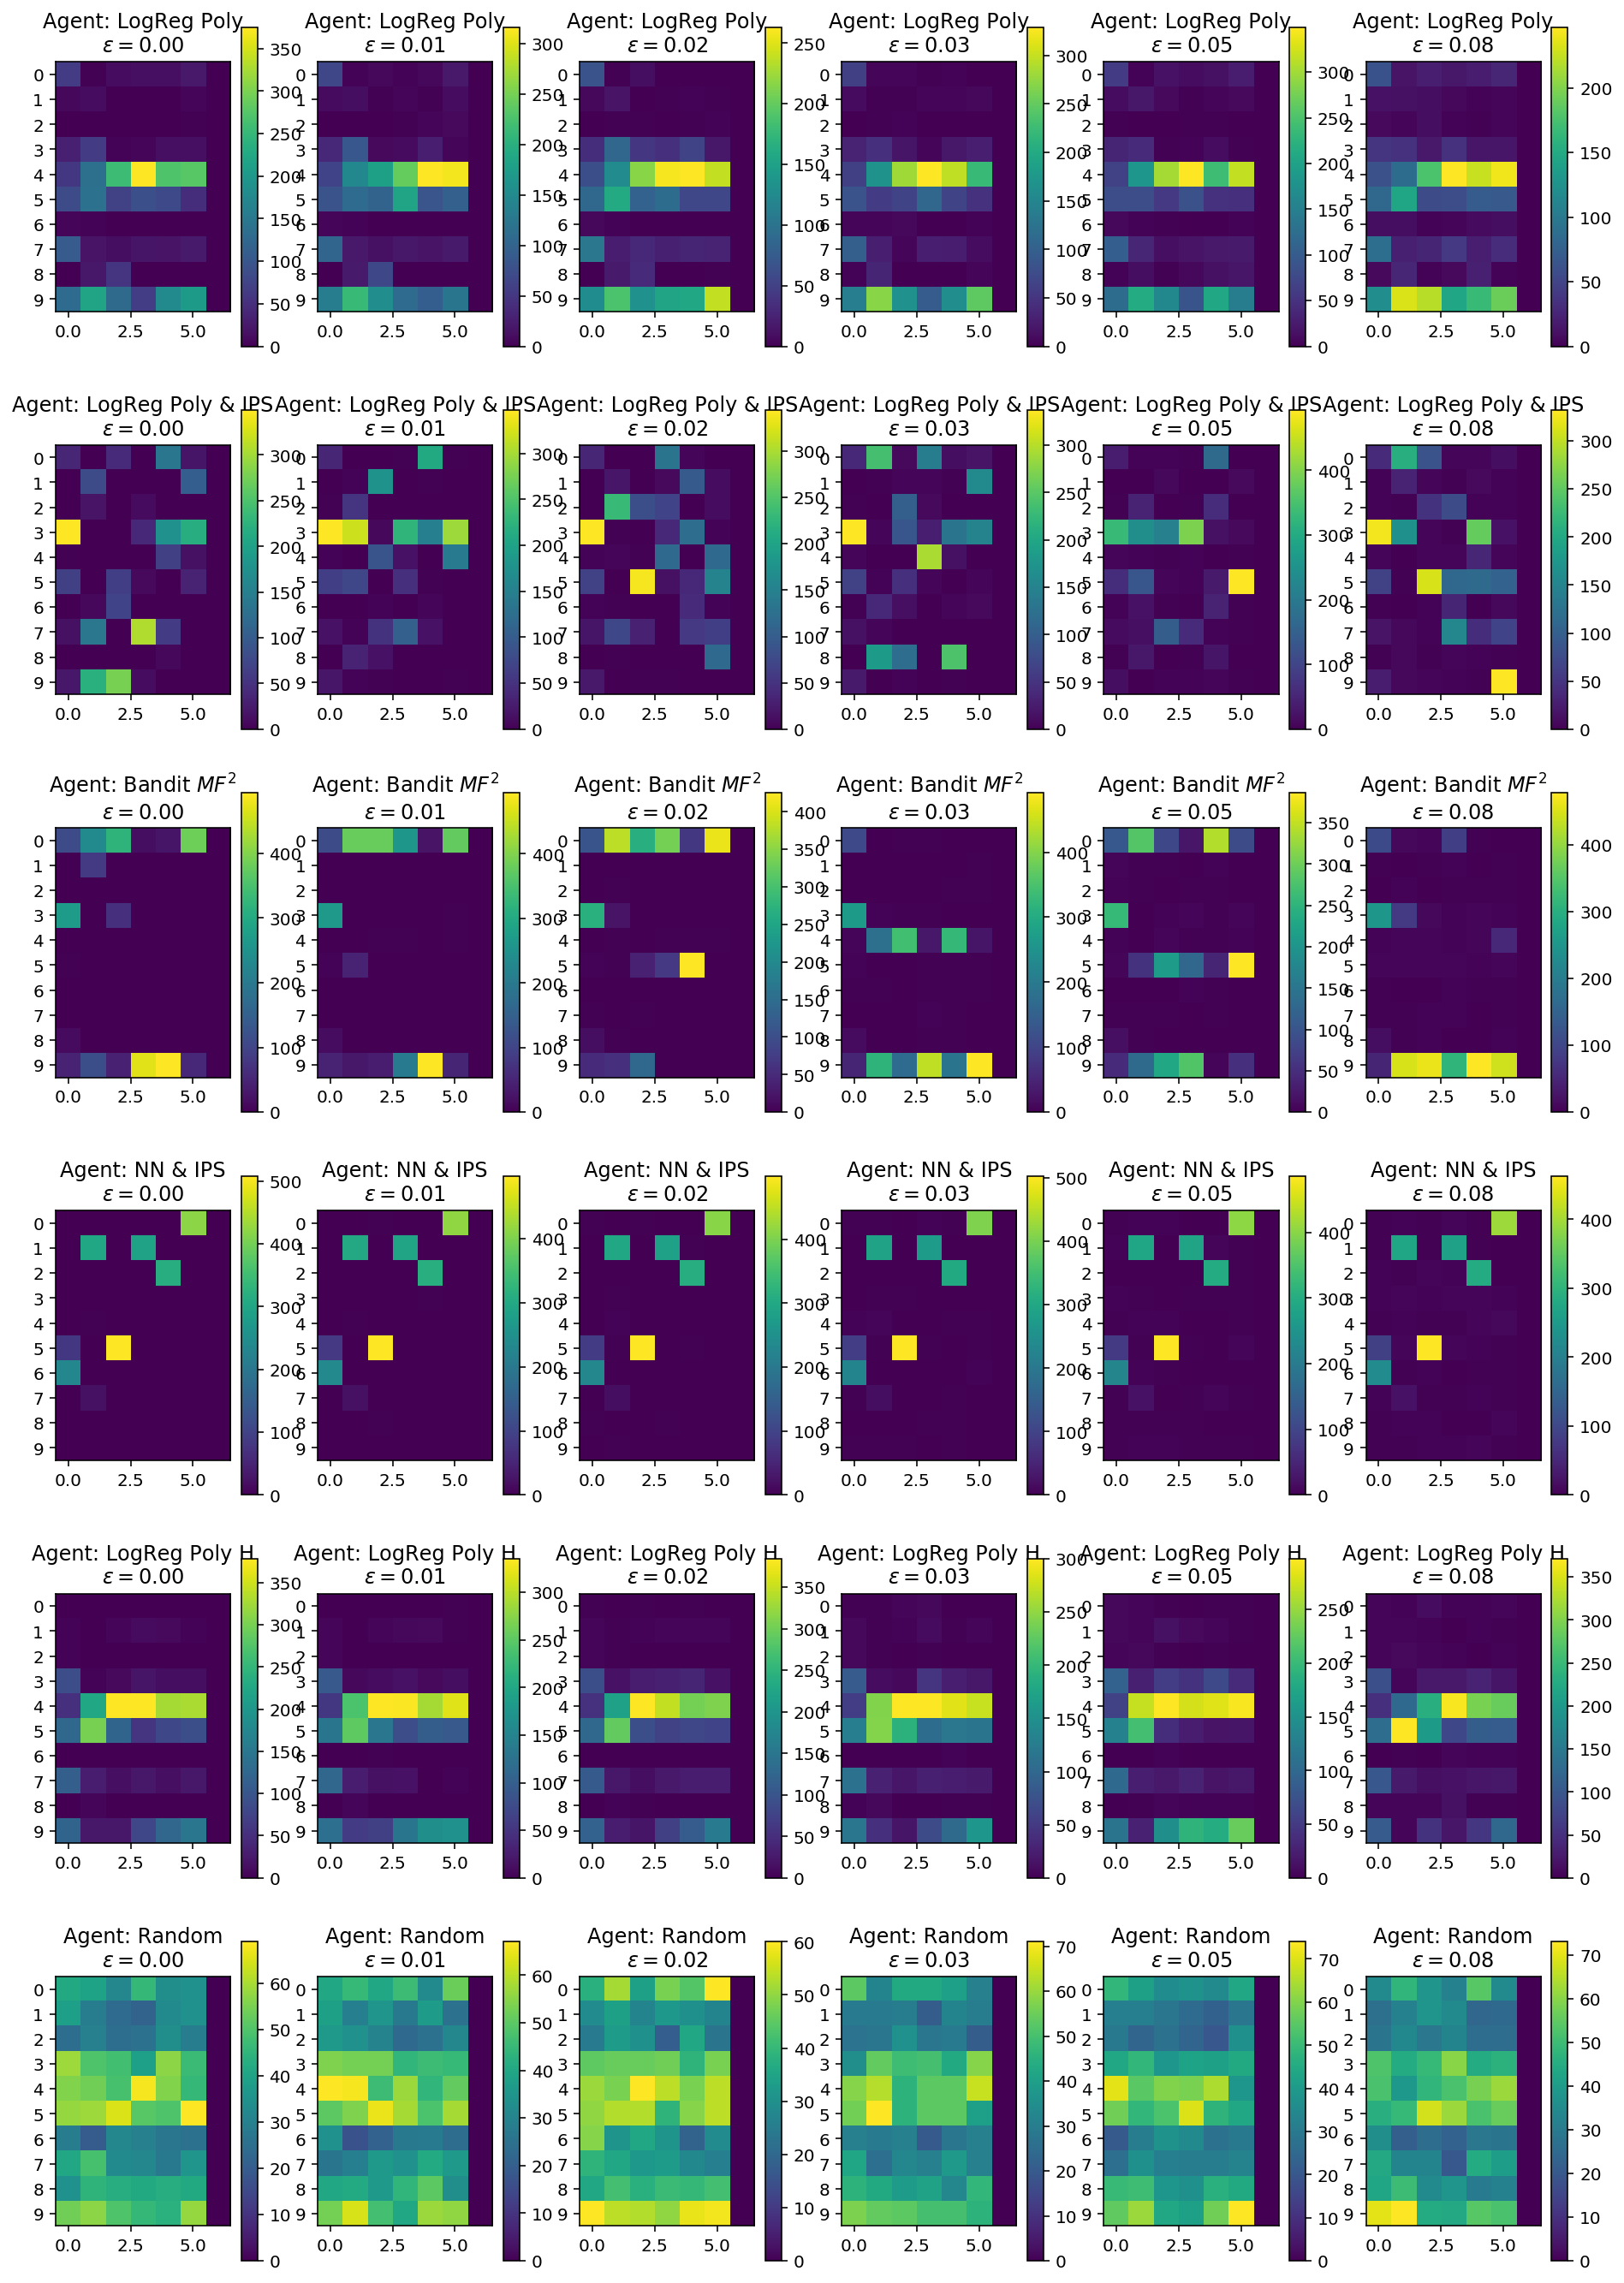

In [6]:
plot_heat_actions(stats_all_data)

### Model Retraining: All _Exploration_ Data

In this case, a _Model_ is retrained with data obtained during _Epsilon_ Policy Selection.

**Note:** here, like in the previous example, the very first set of samples are used in training.

In [7]:
stats_all_explorations = build_exploration_data(env, agents, TrainingApproach.ALL_EXPLORATION_DATA)

Agent: LogReg Poly
Start: ε = 0.00
Start: ε = 0.02
Start: ε = 0.01
Start: ε = 0.03
Start: ε = 0.08
Start: ε = 0.05
End: ε = 0.00 (1076.7963938713074s)
End: ε = 0.05 (1142.1010105609894s)
End: ε = 0.01 (1212.933031320572s)
End: ε = 0.03 (1286.2514357566833s)
End: ε = 0.02 (1288.275344133377s)
End: ε = 0.08 (1329.5266513824463s)
Agent: LogReg Poly & IPS
Start: ε = 0.00
Start: ε = 0.03
Start: ε = 0.05
Start: ε = 0.01
Start: ε = 0.08
Start: ε = 0.02
End: ε = 0.00 (477.1961989402771s)
End: ε = 0.03 (479.38102984428406s)
End: ε = 0.01 (482.2207136154175s)
End: ε = 0.08 (497.18314266204834s)
End: ε = 0.05 (505.6644768714905s)
End: ε = 0.02 (509.334881067276s)
Agent: Bandit $MF^2$
Start: ε = 0.01
Start: ε = 0.00
Start: ε = 0.02
Start: ε = 0.03
Start: ε = 0.08
Start: ε = 0.05
End: ε = 0.01 (154.91910481452942s)
End: ε = 0.02 (160.03950428962708s)
End: ε = 0.03 (170.81269145011902s)
End: ε = 0.05 (171.06808376312256s)
End: ε = 0.00 (204.02881622314453s)
End: ε = 0.08 (227.5411388874054s)
Agent: 

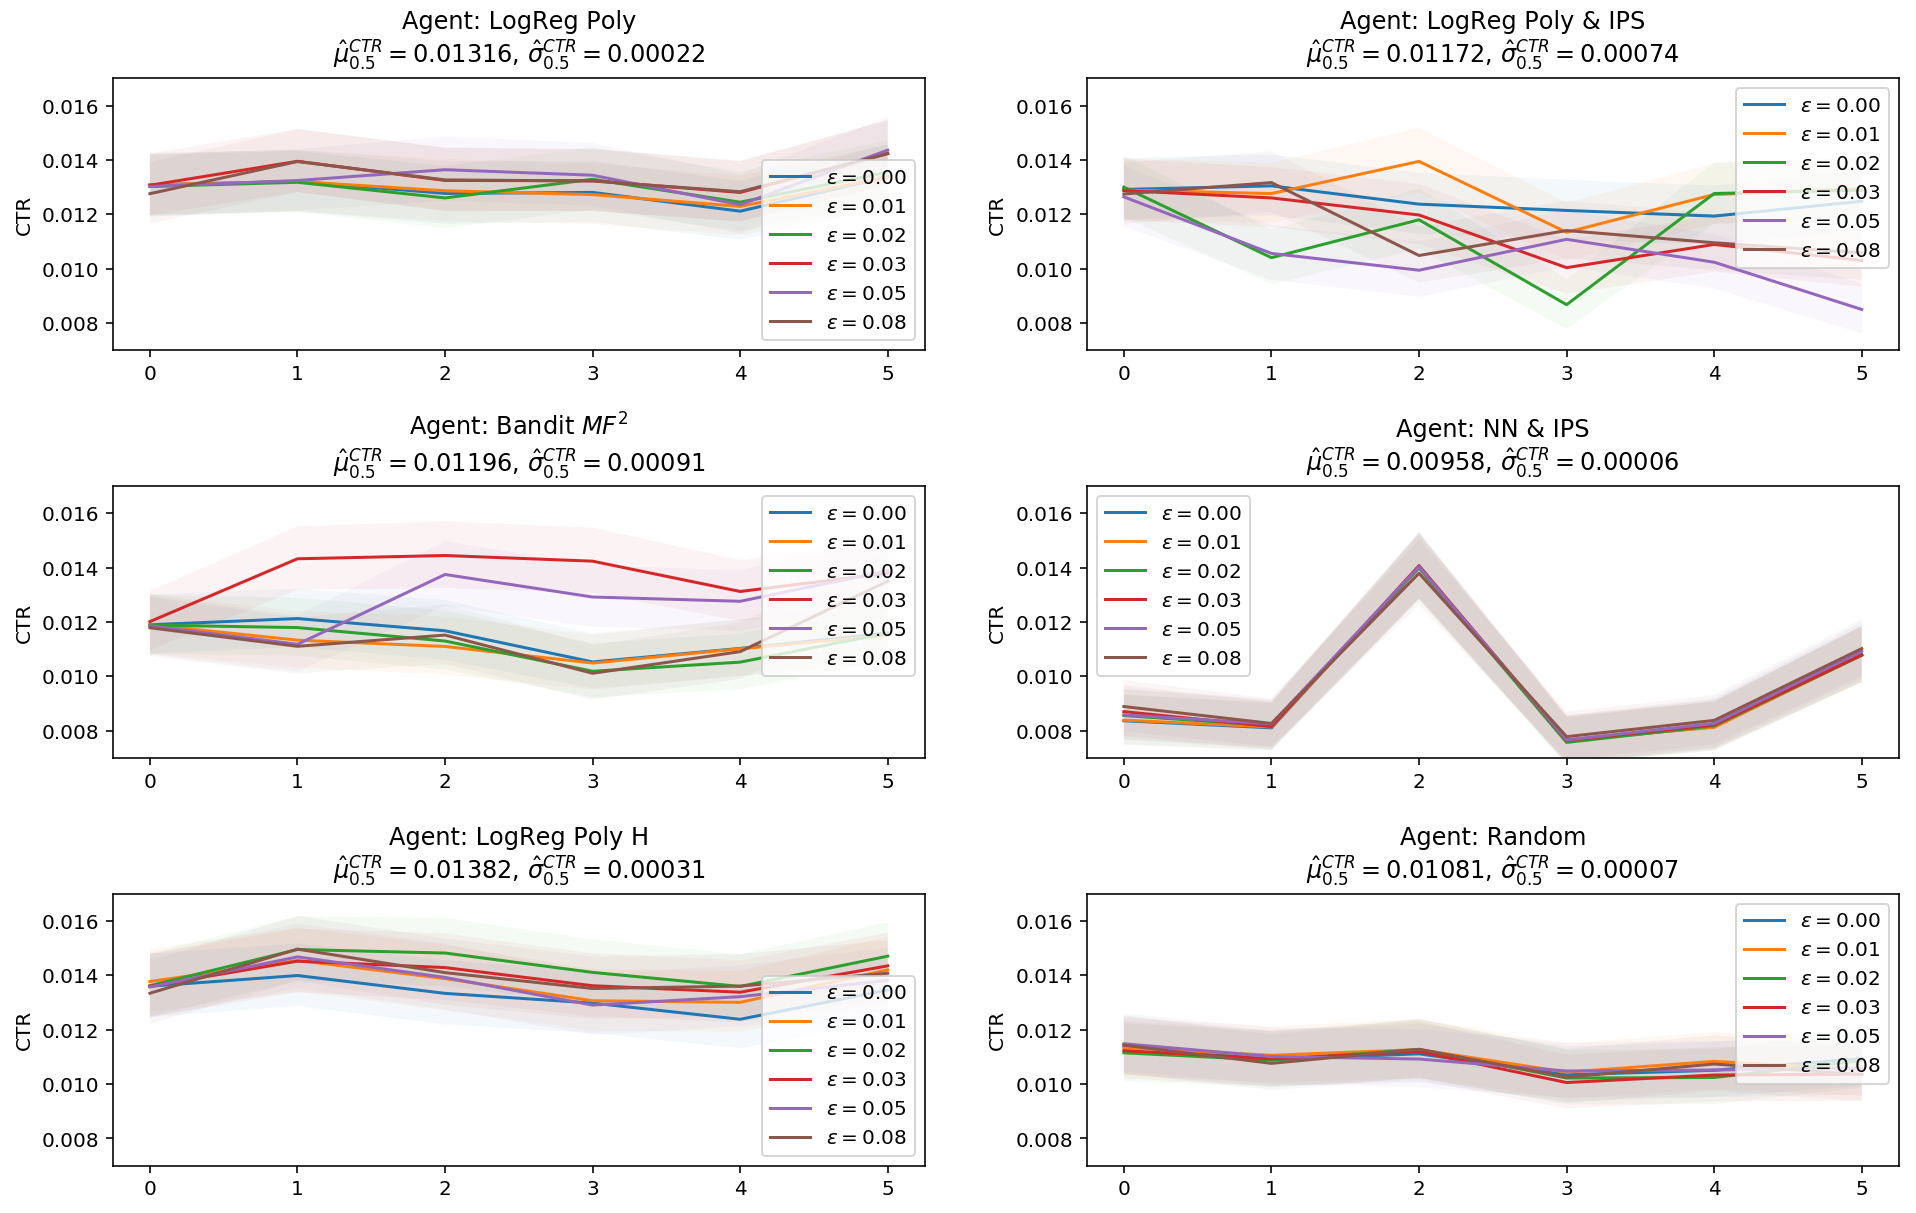

In [8]:
plot_evolutions(stats_all_explorations)

Because during each evaluation step, a volume of sample data grows, the _Models_ starts behaving better.

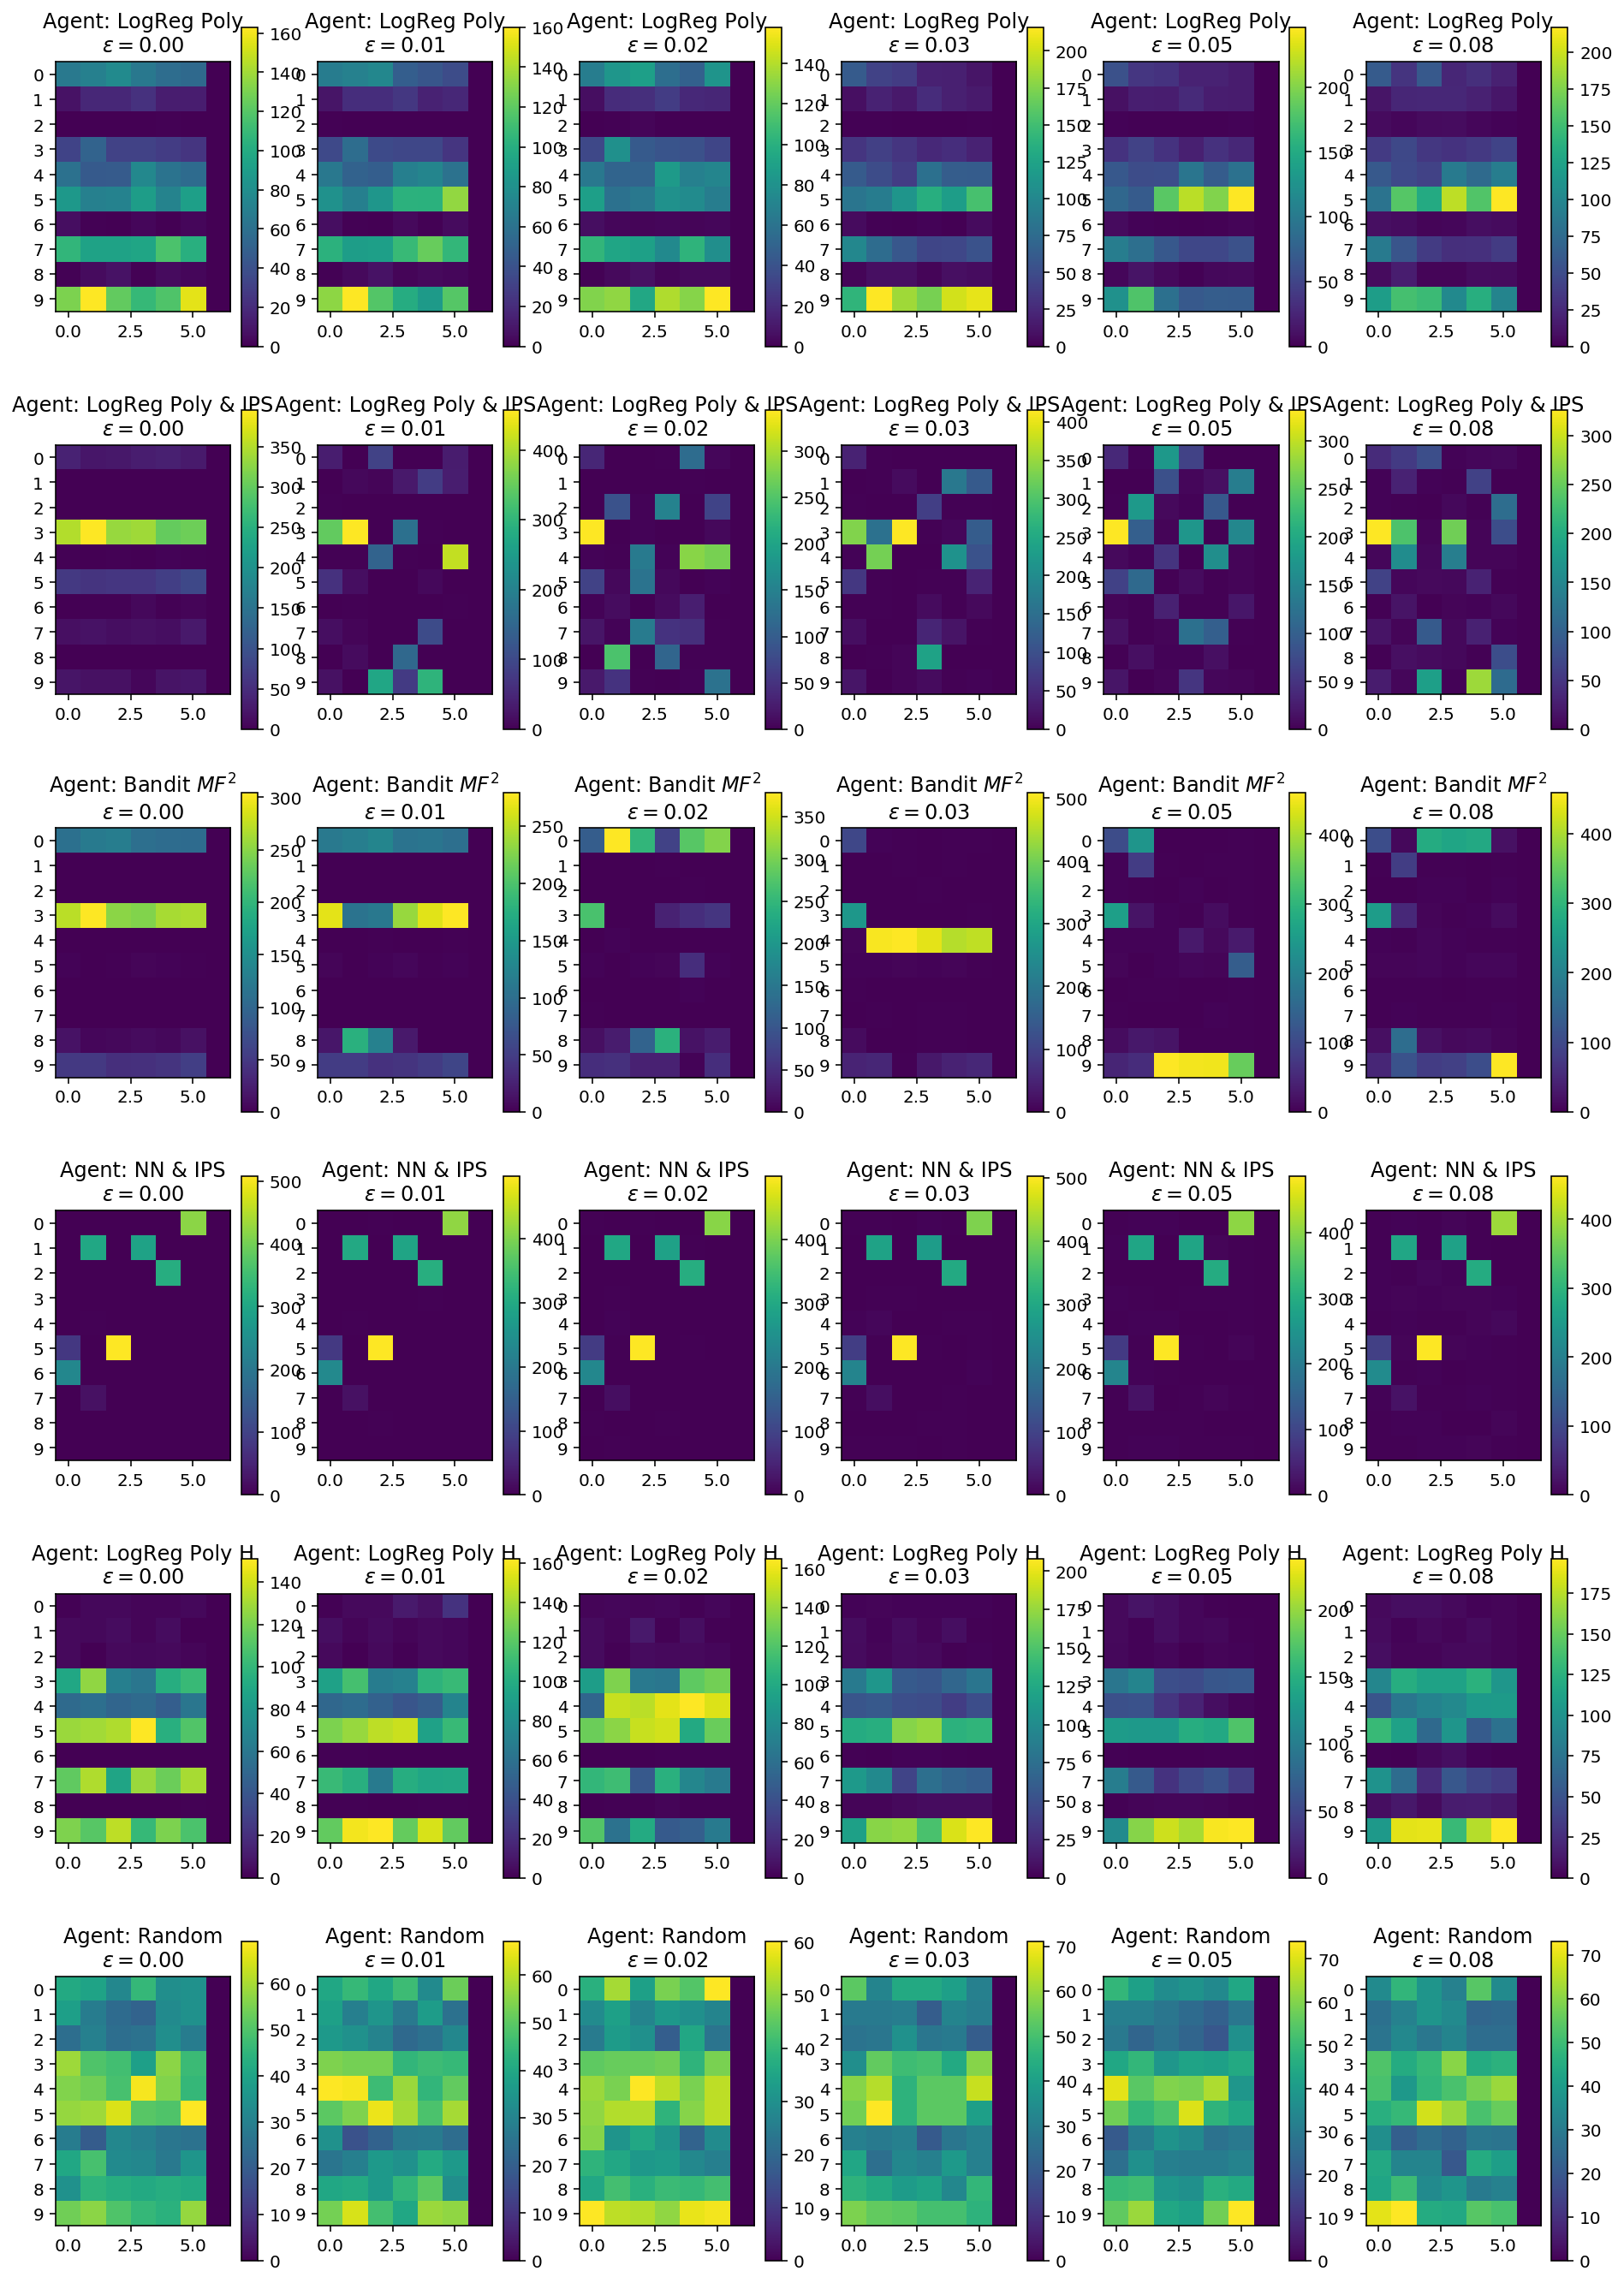

In [9]:
plot_heat_actions(stats_all_explorations)

### Model Retraining: the _Latest_ Set of Data

In this case, a set of the latest samples of data is considered. I.e. a certain _**fixed**_ sliding window of training data samples are used to retrain models.

In [10]:
stats_last_steps = build_exploration_data(env, agents, TrainingApproach.LAST_STEP)

Agent: LogReg Poly
Start: ε = 0.02
Start: ε = 0.03
Start: ε = 0.00
Start: ε = 0.01
Start: ε = 0.05
Start: ε = 0.08
End: ε = 0.05 (984.0231339931488s)
End: ε = 0.02 (990.0515377521515s)
End: ε = 0.00 (993.5175511837006s)
End: ε = 0.01 (1029.7566566467285s)
End: ε = 0.03 (1049.0090999603271s)
End: ε = 0.08 (1062.8135085105896s)
Agent: LogReg Poly & IPS
Start: ε = 0.01
Start: ε = 0.08
Start: ε = 0.00
Start: ε = 0.02
Start: ε = 0.05
Start: ε = 0.03
End: ε = 0.02 (461.0214595794678s)
End: ε = 0.00 (466.772319316864s)
End: ε = 0.01 (472.4946508407593s)
End: ε = 0.03 (482.30445885658264s)
End: ε = 0.05 (486.8180754184723s)
End: ε = 0.08 (528.4872469902039s)
Agent: Bandit $MF^2$
Start: ε = 0.02
Start: ε = 0.01
Start: ε = 0.05
Start: ε = 0.00
Start: ε = 0.08
Start: ε = 0.03
End: ε = 0.00 (222.4774854183197s)
End: ε = 0.03 (225.32870149612427s)
End: ε = 0.02 (228.7017960548401s)
End: ε = 0.01 (228.79170870780945s)
End: ε = 0.05 (228.84682631492615s)
End: ε = 0.08 (237.1278941631317s)
Agent: NN &

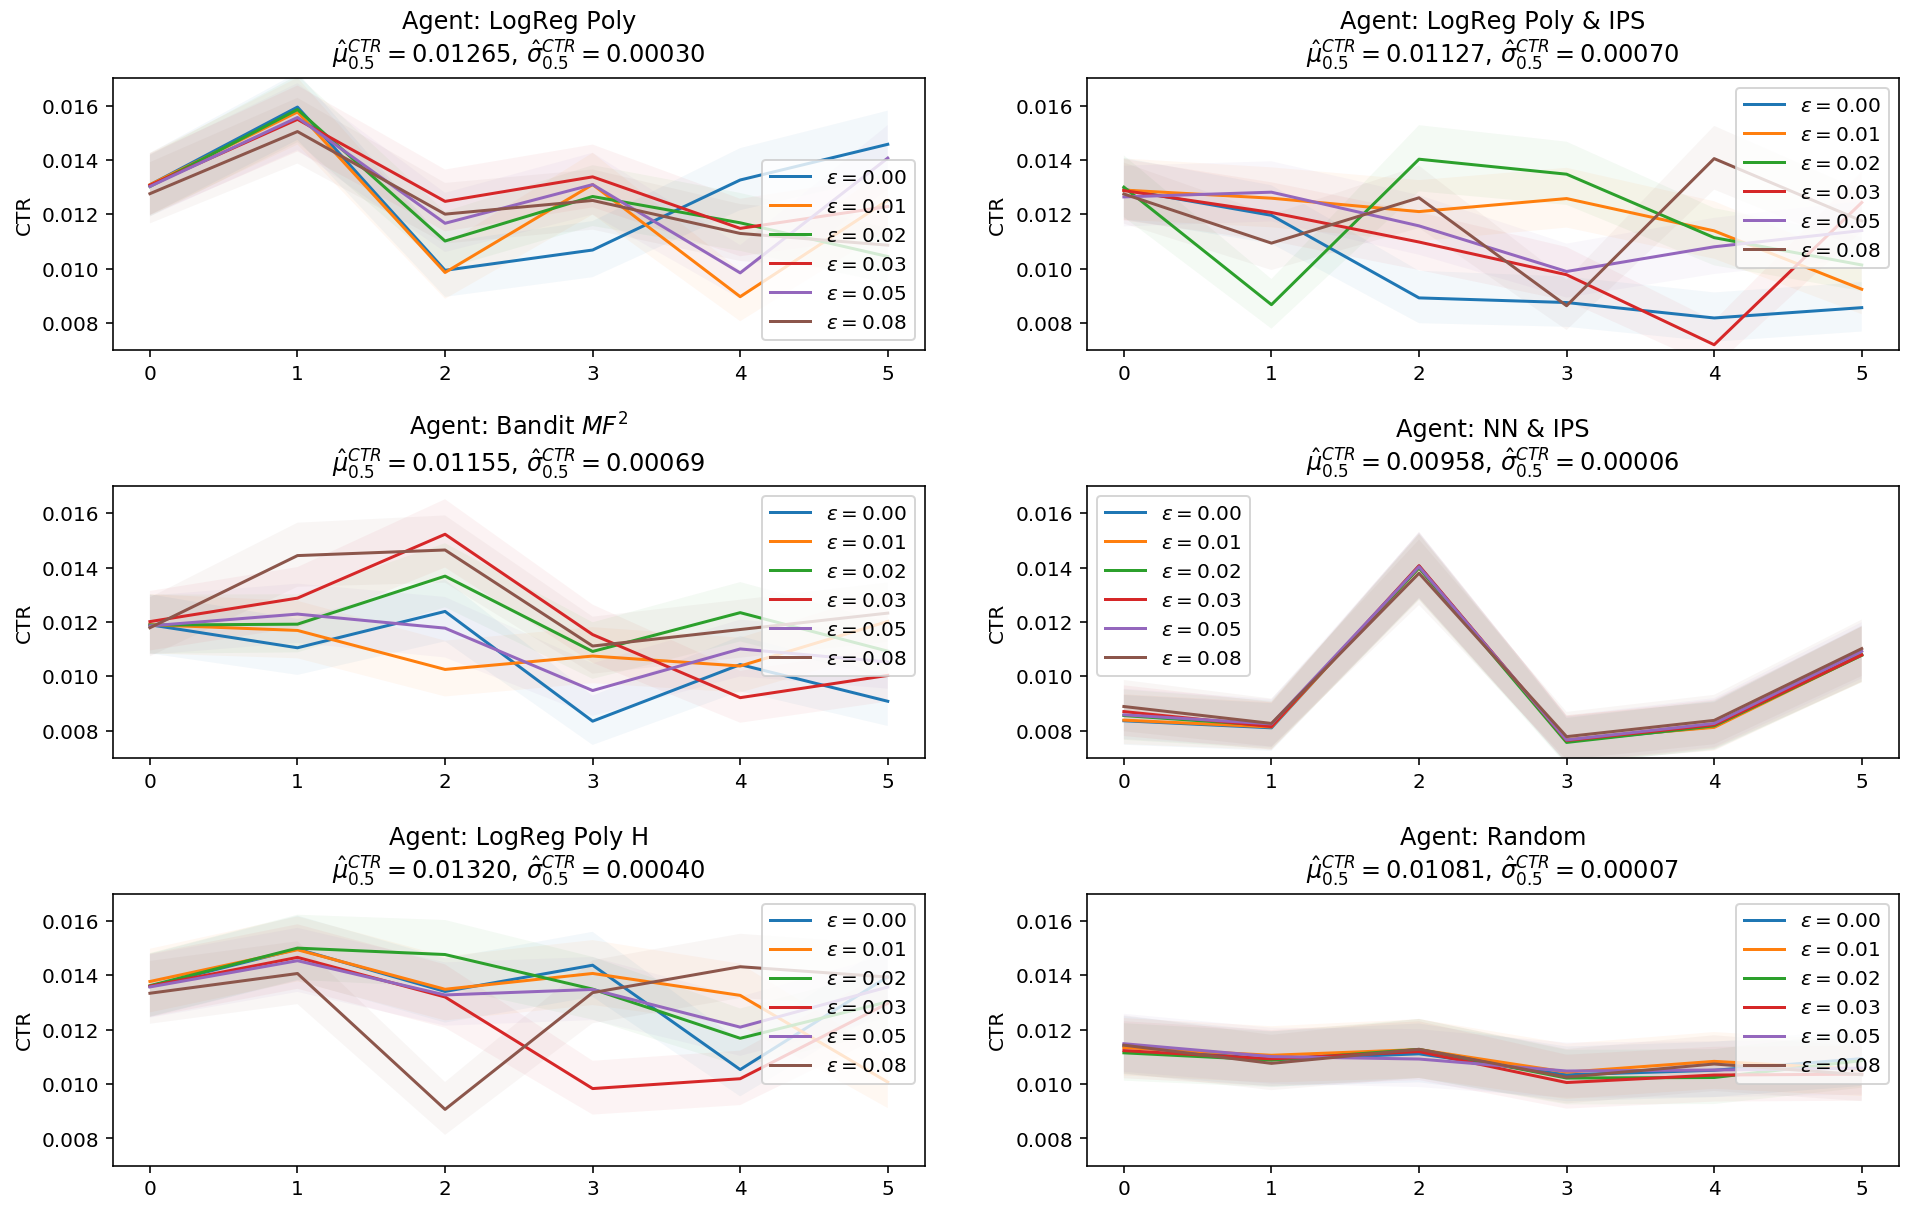

In [11]:
plot_evolutions(stats_last_steps)

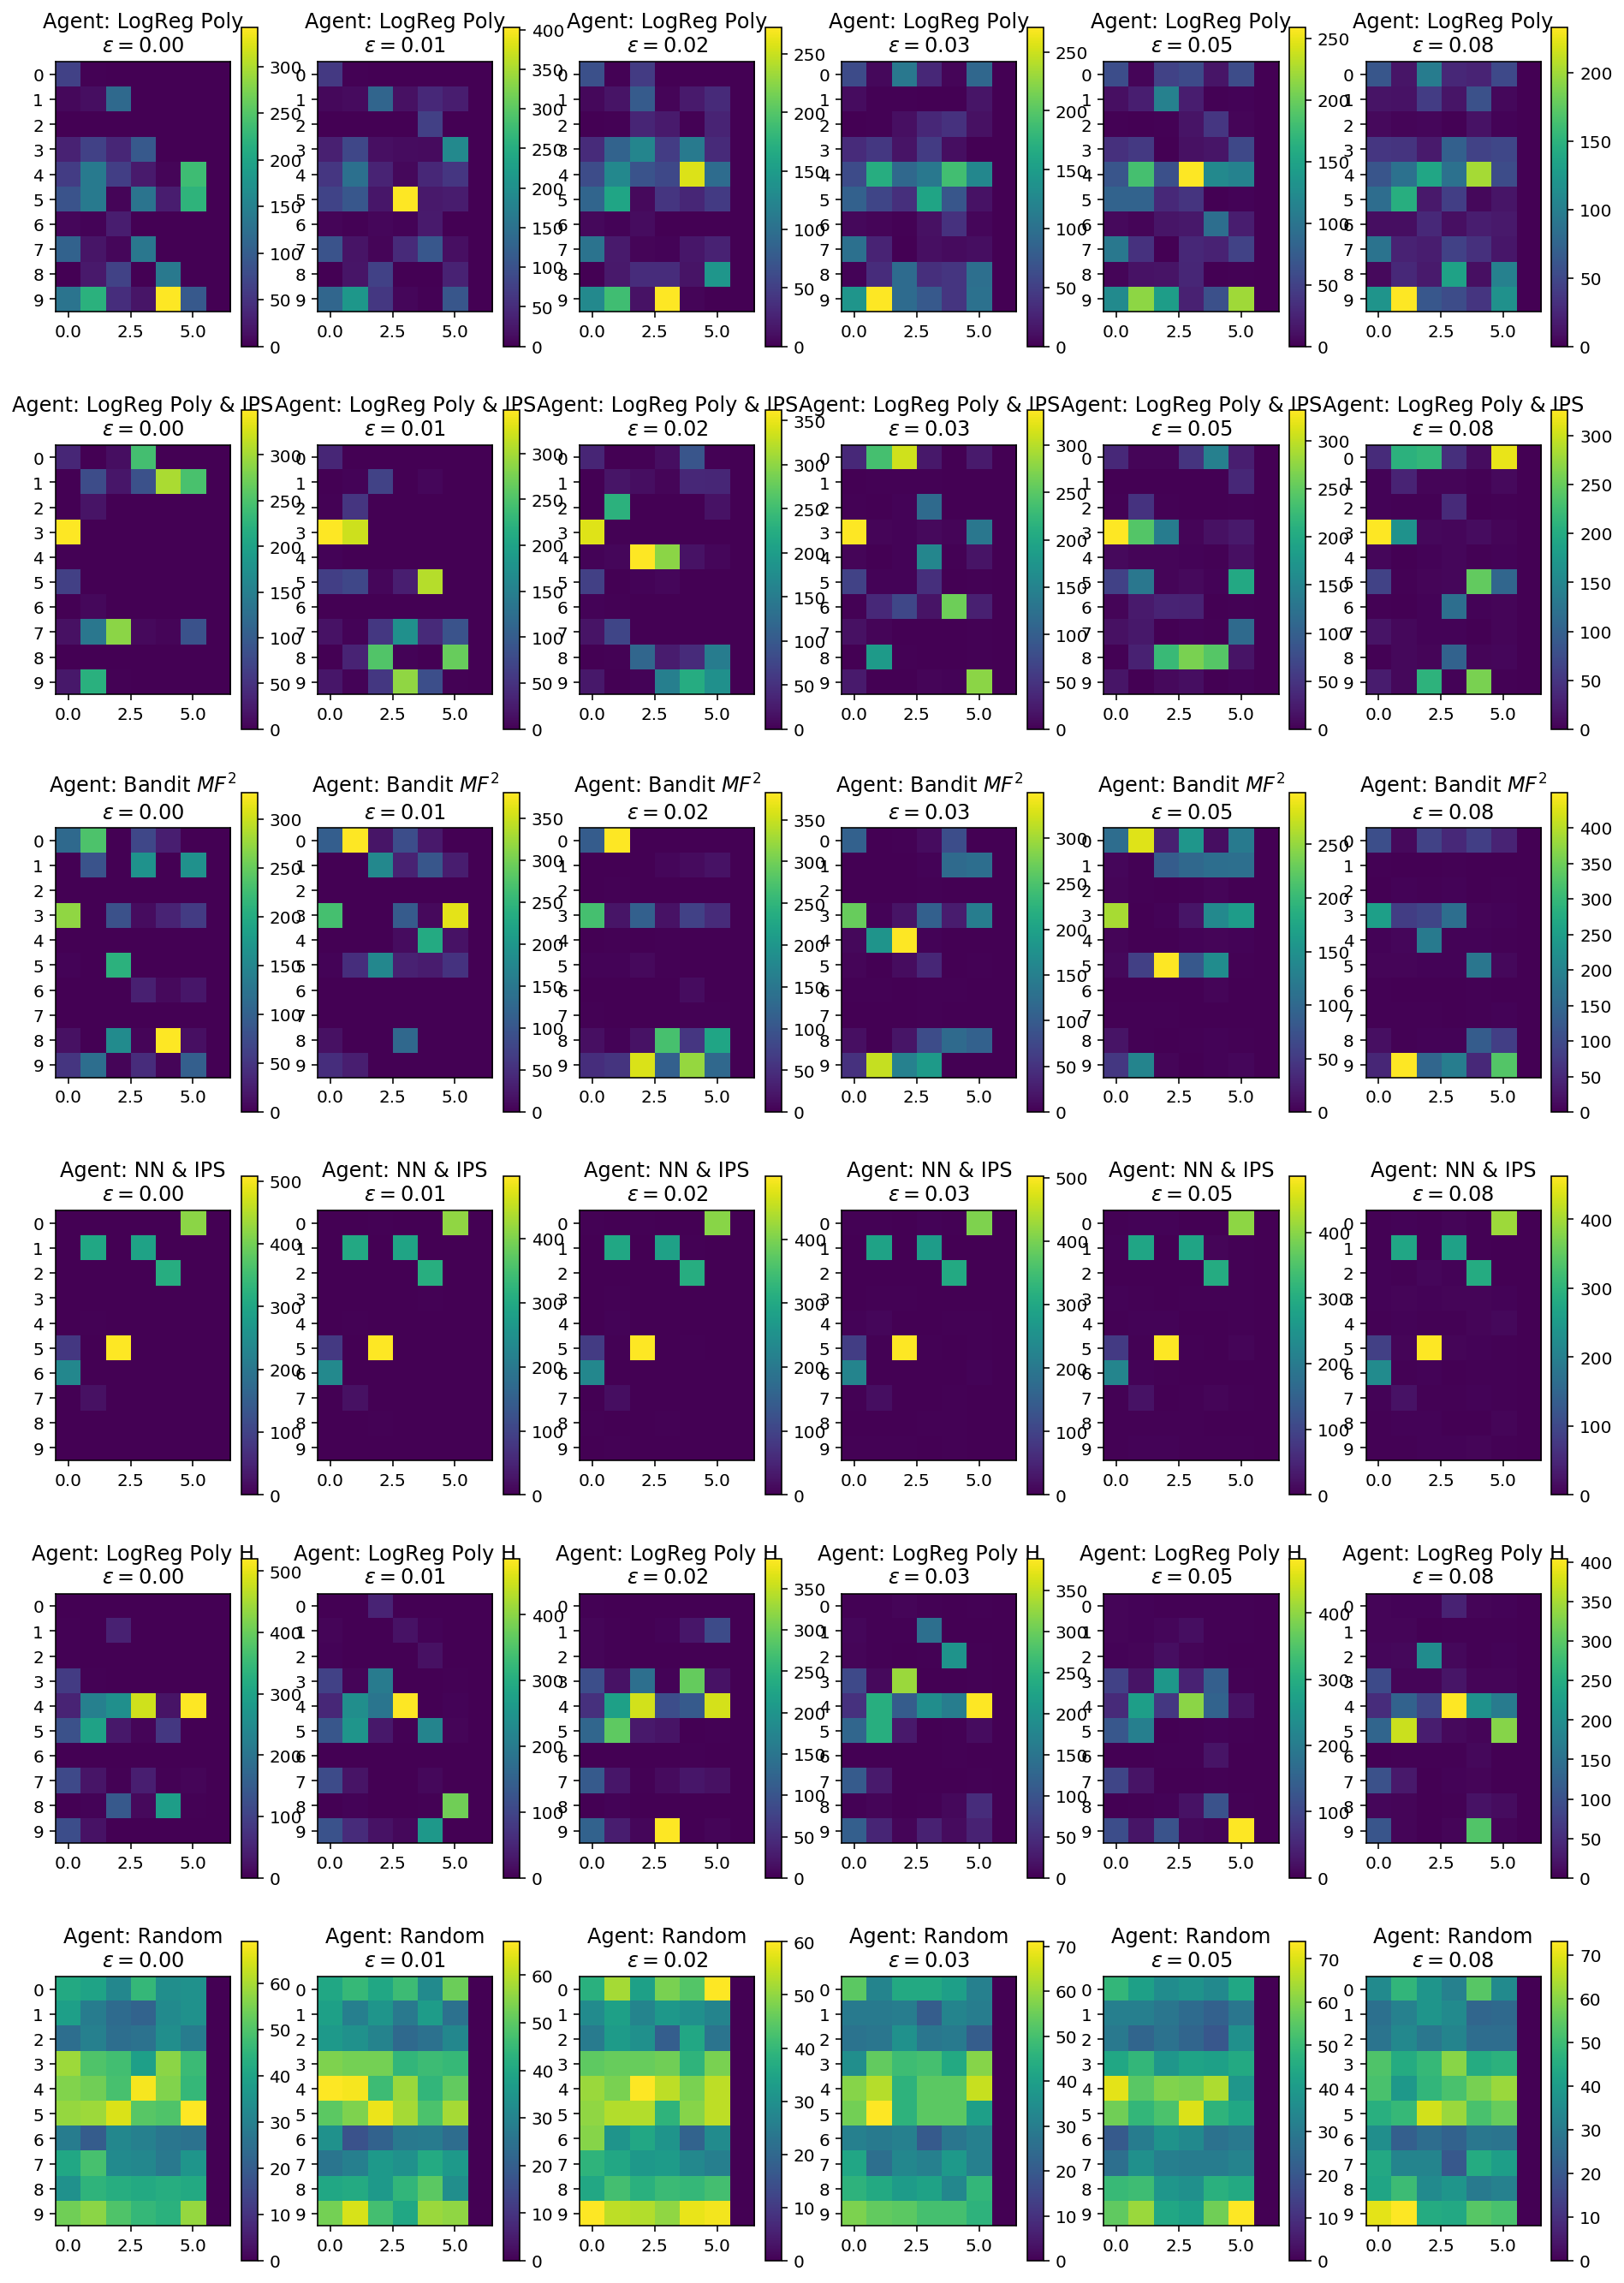

In [12]:
plot_heat_actions(stats_last_steps)

## User Personalised Environment

In all previous experiments, the _`Environment`_ was configured to be quite _impersonlised_ because the value of $\mu_{\beta}$ (_Nonpersonalised Click-Through Rate Contribution_) was quite big (the default value is _`3`_).

This time we launch experiments when _`Environment`_ is very _personolised_.

In [13]:
env_pers = deepcopy(env)

env_pers.init_gym({
    **env_1_args,
    'sigma_mu_organic': 0.01 # User personalised Environment.
})

In [14]:
stats_last_steps_pers = build_exploration_data(env_pers, agents, TrainingApproach.LAST_STEP)

Agent: LogReg Poly
Start: ε = 0.00
Start: ε = 0.01
Start: ε = 0.08
Start: ε = 0.03
Start: ε = 0.02
Start: ε = 0.05
End: ε = 0.02 (764.8007791042328s)
End: ε = 0.05 (779.4737367630005s)
End: ε = 0.00 (800.2508292198181s)
End: ε = 0.08 (824.9933595657349s)
End: ε = 0.03 (830.6122958660126s)
End: ε = 0.01 (838.6943891048431s)
Agent: LogReg Poly & IPS
Start: ε = 0.00
Start: ε = 0.02
Start: ε = 0.05
Start: ε = 0.01
Start: ε = 0.08
Start: ε = 0.03
End: ε = 0.00 (465.073837518692s)
End: ε = 0.02 (465.31956362724304s)
End: ε = 0.01 (466.9376425743103s)
End: ε = 0.03 (476.5186607837677s)
End: ε = 0.08 (484.70138573646545s)
End: ε = 0.05 (492.279287815094s)
Agent: Bandit $MF^2$
Start: ε = 0.01
Start: ε = 0.00
Start: ε = 0.05
Start: ε = 0.03
Start: ε = 0.08
Start: ε = 0.02
End: ε = 0.02 (292.25174379348755s)
End: ε = 0.01 (295.259966135025s)
End: ε = 0.00 (296.13384985923767s)
End: ε = 0.05 (298.2067663669586s)
End: ε = 0.03 (298.2387104034424s)
End: ε = 0.08 (302.28136229515076s)
Agent: NN & IPS

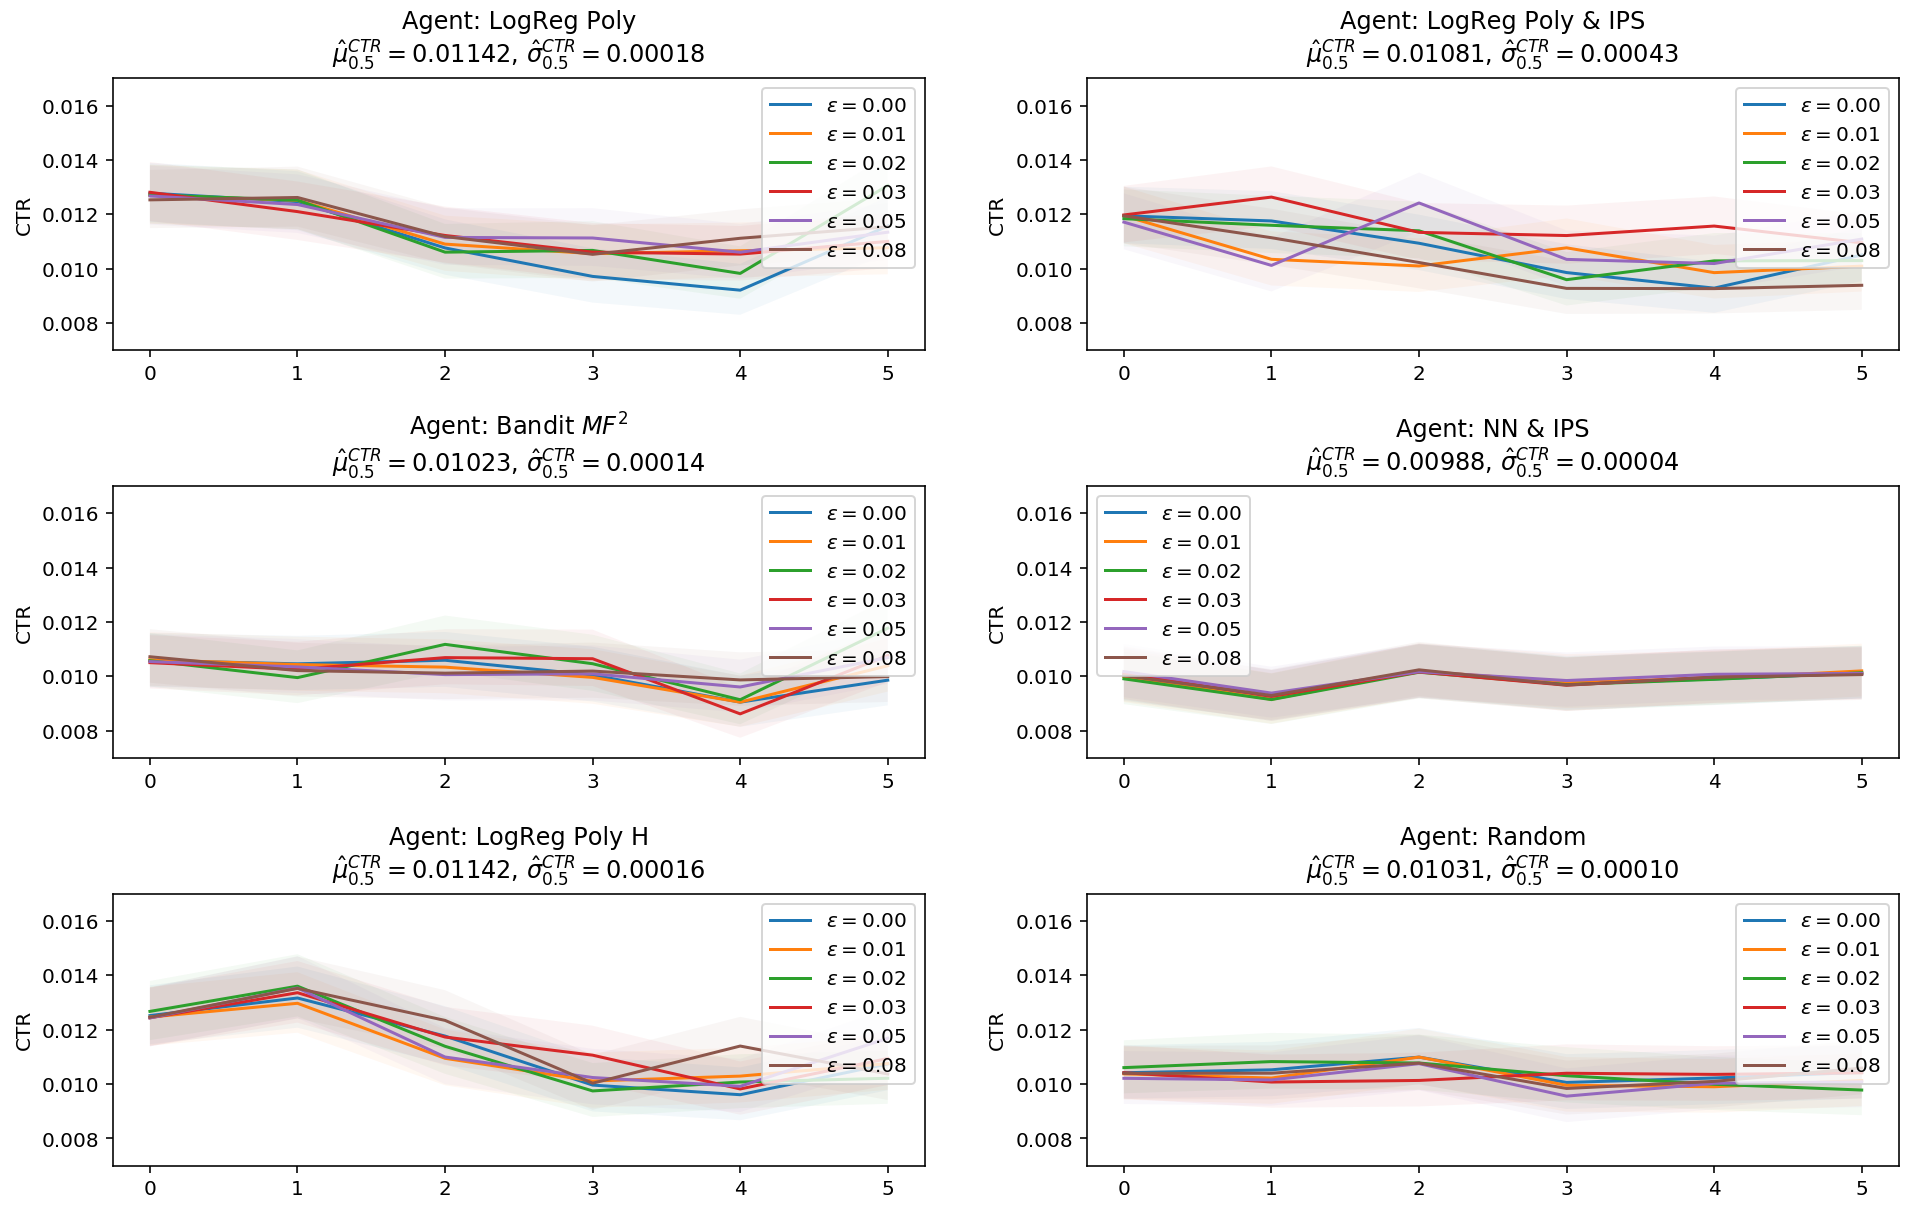

In [15]:
plot_evolutions(stats_last_steps_pers)

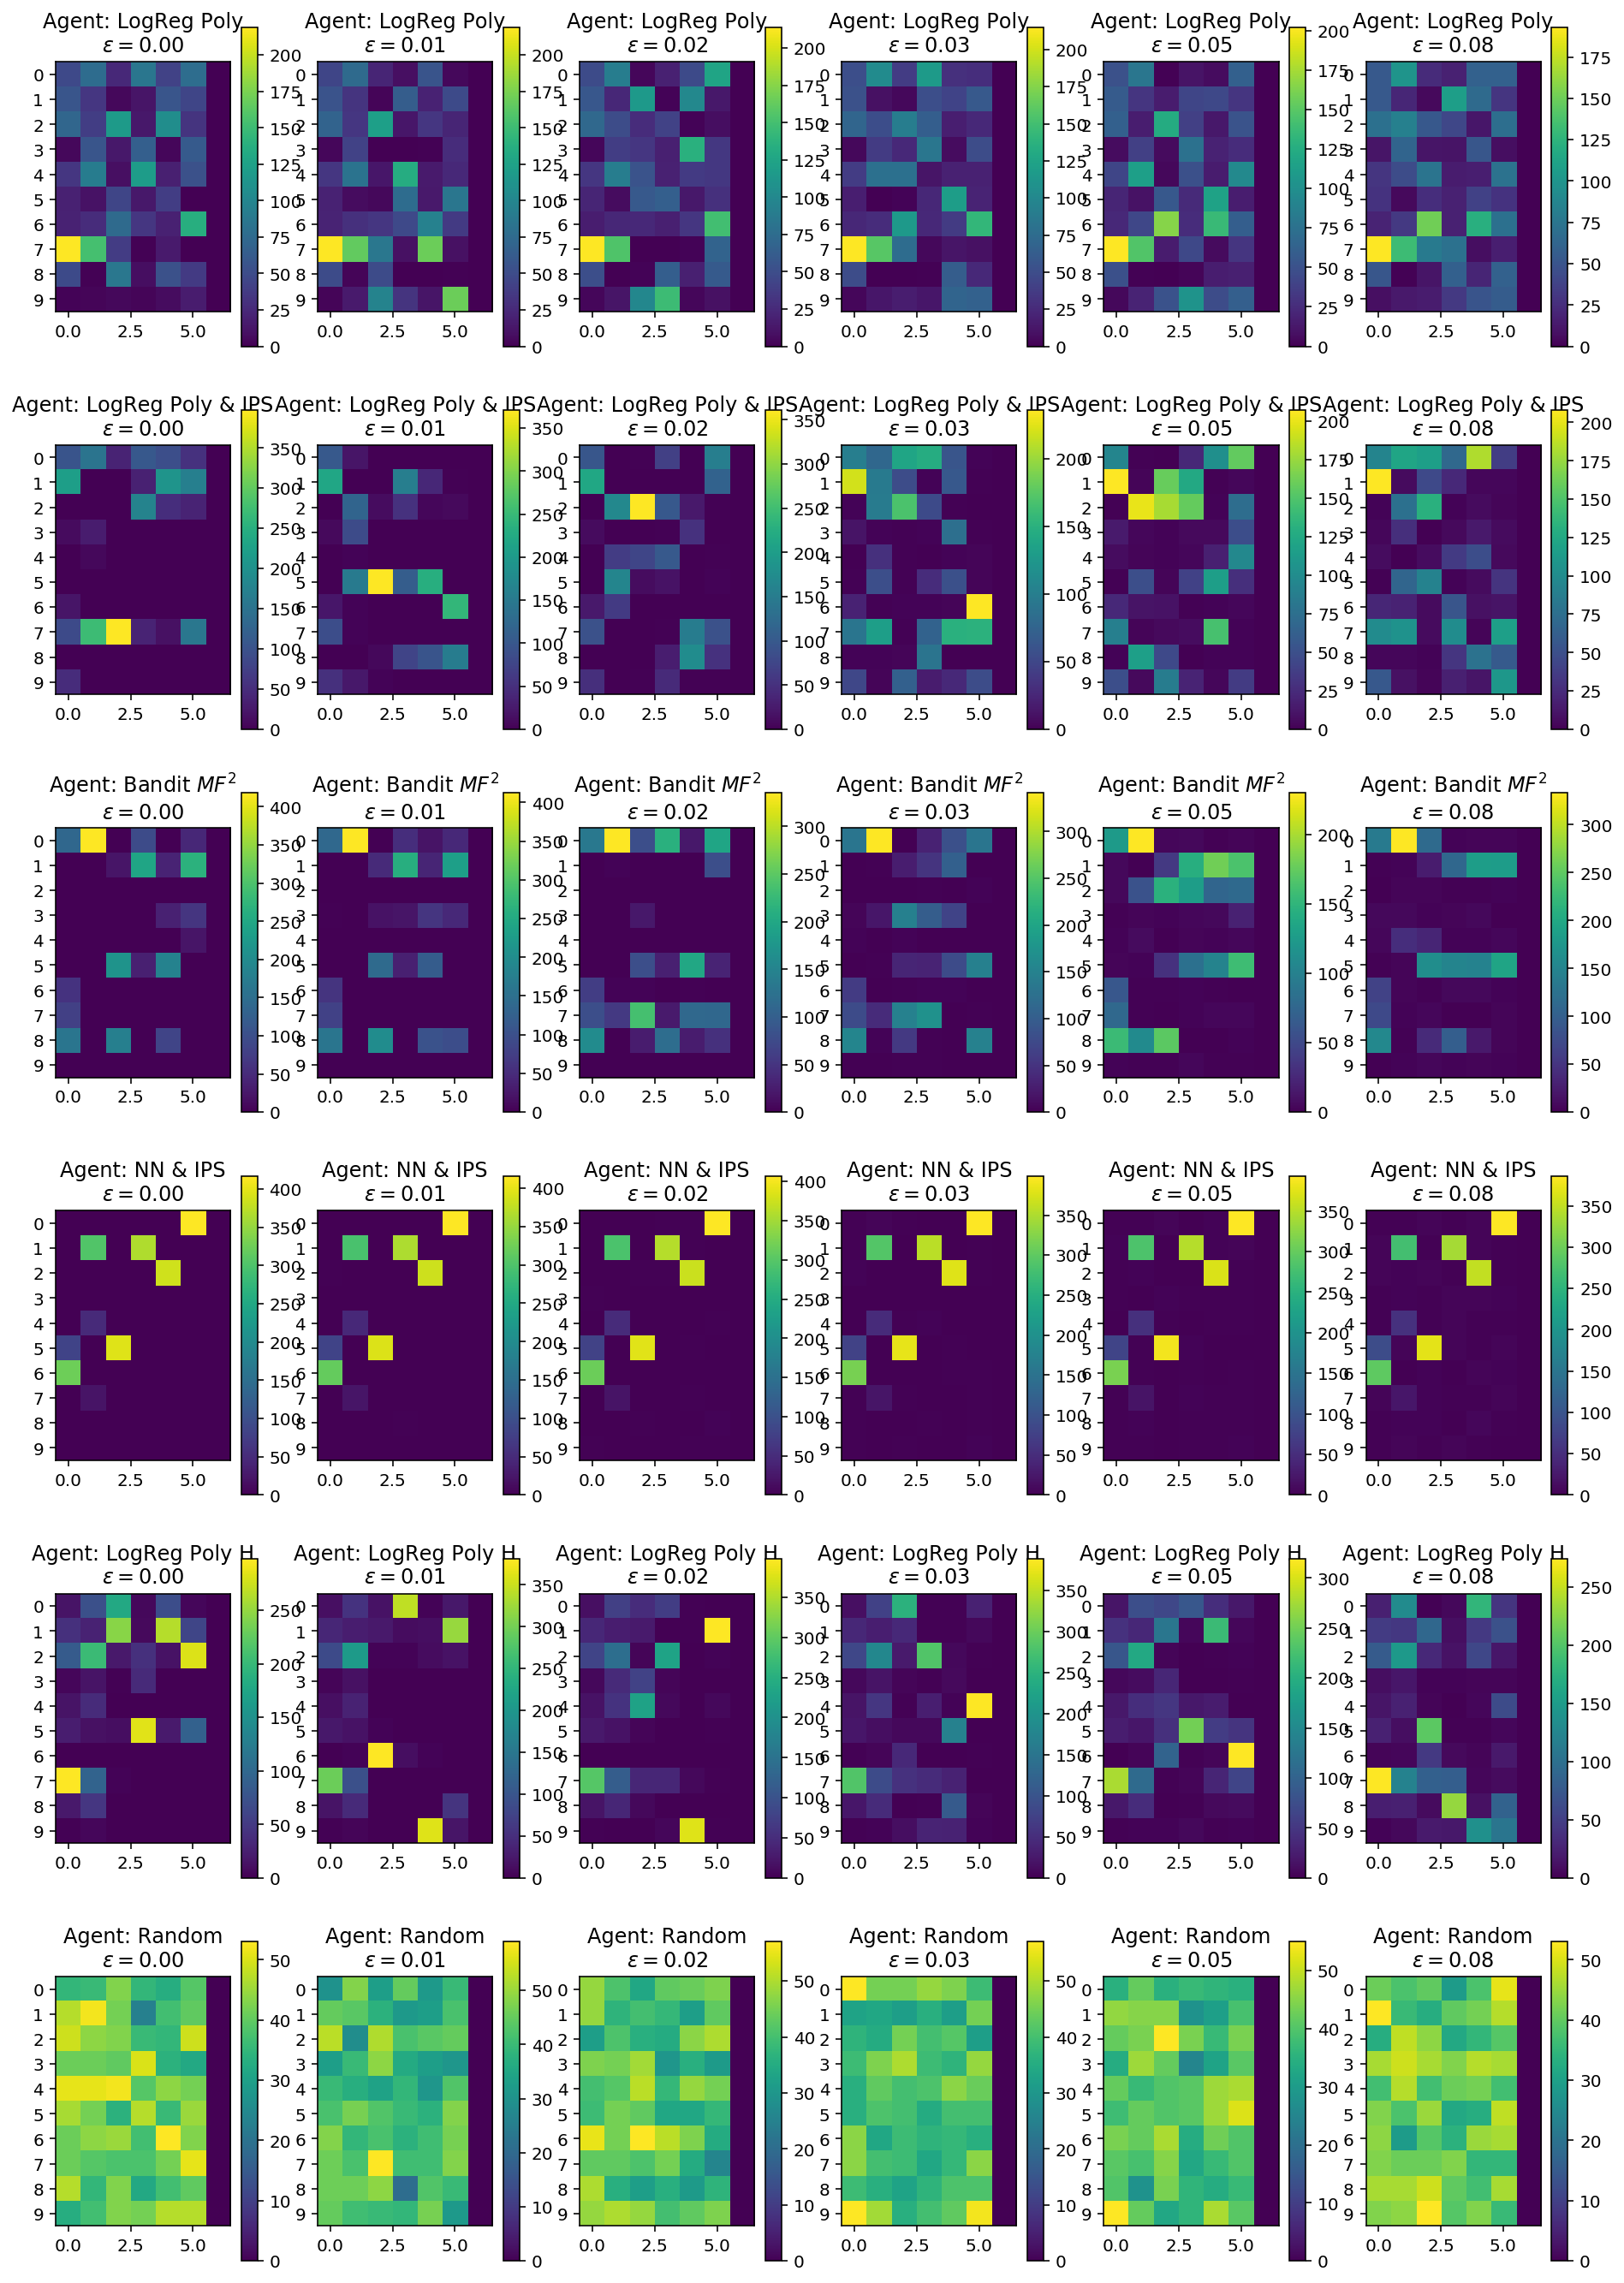

In [16]:
plot_heat_actions(stats_last_steps_pers)

## Exploration Amends

The performance of _`Agents`_ was considered _irrespectively_ to the price that was paid for the using of the _Exploration_ Selection Policy. This time, the impact of the utilising _Exploration_ Selection Policy is considered more _intently_. Therefore, _the price_ that is paid for the usage of the _Exploration_ Selection Policy is scrutinised to get insight about the benefit that is obtained when new data are incorporated in updated _Models_.

Also, the impact of applying _Exploration_ Selection Policy on _the state of the user_ is considered: it is estimated how that correlated with the case when only _Explotate_ Selection Policy would have been applied.

### Return of Investment

When _Explore_ Selection Policy is used then instead of using an _`Action`_ predicted by an _Old Model_, a _random_ _`Action`_ is provided. We _**definitely**_ pay a certain price by using _Exploration_ as usually a randomly selected _`Action`_ is used that is _**worse**_ than the _`Action`_ predicted by the _Old Model_. However, we consider that as an _Investment_ that might help us to get some earnings in a _long-term_ via getting more valuable training cases those would not have been available in the case when the _Old Model_ had been applied.


Thus, to estimate how efficient the _Investment_ is, it is evaluated via using _Return of Investment_ that is calculated as following:

$$ ROI_{t+1} = \frac{\frac{\sum \delta'_{i_{t+1}'}}{1 - \varepsilon} - \sum \delta_{i_{t+1}}}{\varepsilon \sum \delta_{i_{t}}} $$

* $
\delta_i =
\begin{cases}
    1,& \text{if there is a click}\\
    0,& \text{otherwise}
\end{cases}
$

The value of $\delta$ is calculated as if the _Old Model_ had been applied.

* $\delta'_{i'}$ is calculated via applying the _New Model_, i.e. the model that is created from the data obtained via usage of _Exploration_ Selection Policy.

* $\varepsilon \sum_i \delta_{i_{t}}$ is an estimated lost of applying Epsilon-Greedy Selection Policy.

**Note:** different indexes $i$ and $i'$ are used there as, in general, via using a different model, the states of the system will be different, thus amoung of _Bandit_ _`Events`_ will be different as well.

In [17]:
from enum import Enum


class Metrics(Enum):
    ROI_MEAN = 0
    ROI_0_025 = 1
    ROI_0_975 = 2
    ROI_SUCCESS = 3
    ROI_FAILURE = 4


def plot_roi(
        agent_evolution_stats,
        max_agents_per_row = 2
):
    """
    A helper function that calculates Return of Investment (ROI) for applying Epsilon-Greedy Selection Policy.

    :param agent_evolution_stats: statistic about Agent evolution collected in `build_exploration_data'.

         :param max_agents_per_row: how many graphs should be drawn per a row

    :return: a dictionary of Agent ROI after applying Epsilon-Greedy Selection Strategy in the following form:
        {
            'Agent Name': {
                'Epsilon Value': {
                    Metrics.ROI: [an array of ROIs for each ith step (starting from 1st step)]
                }
            }
        }
    """
    epsilons = generate_epsilons()
    figs, axs = plt.subplots(
        int(len(agent_evolution_stats) / max_agents_per_row),
        max_agents_per_row,
        figsize = (16, 8),
        squeeze = False
    )
    labels = [("$\epsilon=$" + format_epsilon(epsilon)) for epsilon in epsilons if epsilon != 0.0]

    agent_roi_stats = dict()

    for (ix, agent_key) in enumerate(agent_evolution_stats):
        ax = axs[int(ix / max_agents_per_row), int(ix % max_agents_per_row)]
        agent_stat = agent_evolution_stats[agent_key]
        zero_epsilon_key = format_epsilon(0)
        zero_epsilon = agent_stat[zero_epsilon_key]
        zero_success_evolutions = zero_epsilon[EvolutionCase.SUCCESS]
        zero_failure_evolutions = zero_epsilon[EvolutionCase.FAILURE]
        assert (len(zero_success_evolutions))

        agent_stats = dict()
        roi_mean_means = []
        for epsilon in generate_epsilons():
            if zero_epsilon_key == format_epsilon(epsilon):
                continue

            epsilon_key = format_epsilon(epsilon)
            agent_stats[epsilon_key] = {
                Metrics.ROI_0_025: [],
                Metrics.ROI_MEAN: [],
                Metrics.ROI_0_975: [],
            }
            epsilon_evolutions = agent_stat[epsilon_key]
            success_greedy_evolutions = epsilon_evolutions[EvolutionCase.SUCCESS_GREEDY]
            failure_greedy_evolutions = epsilon_evolutions[EvolutionCase.FAILURE_GREEDY]
            assert (len(success_greedy_evolutions) == len(failure_greedy_evolutions))
            assert (len(zero_success_evolutions) == len(success_greedy_evolutions))
            steps = []
            roi_means = []
            roi_0_025s = []
            roi_0_975s = []
            for step in range(1, len(epsilon_evolutions[EvolutionCase.SUCCESS])):
                previous_zero_successes = zero_success_evolutions[step - 1]
                previous_zero_failures = zero_failure_evolutions[step - 1]
                current_zero_successes = zero_success_evolutions[step]
                current_zero_failures = zero_failure_evolutions[step]
                current_epsilon_greedy_successes = success_greedy_evolutions[step]
                current_epsilon_greedy_failures = failure_greedy_evolutions[step]
                
                def roi_with_confidence_interval(
                    factor,
                    epsilon,
                    previous_zero_successes,
                    previous_zero_failures,
                    current_zero_successes,
                    current_zero_failures,
                    current_epsilon_greedy_successes,
                    current_epsilon_greedy_failures
                ):
                    def roi_formulae(
                        epsilon,
                        previous_zero,
                        current_zero,
                        current_epsilon_greedy
                    ):
                        current_gain = current_epsilon_greedy / (1 - epsilon) - current_zero
                        roi = current_gain / (epsilon * previous_zero)
                        return roi
                    return {
                        Metrics.ROI_SUCCESS: roi_formulae(
                            epsilon,
                            previous_zero_successes,
                            current_zero_successes,
                            current_epsilon_greedy_successes
                        ),
                        Metrics.ROI_FAILURE: roi_formulae(
                            epsilon,
                            previous_zero_failures,
                            current_zero_failures,
                            current_epsilon_greedy_failures
                        )
                    }

                roi_mean = roi_with_confidence_interval(
                    0.5,
                    epsilon,
                    previous_zero_successes,
                    previous_zero_failures,
                    current_zero_successes,
                    current_zero_failures,
                    current_epsilon_greedy_successes,
                    current_epsilon_greedy_failures
                )[Metrics.ROI_SUCCESS]
                roi_0_025 = roi_with_confidence_interval(
                    0.025,
                    epsilon,
                    previous_zero_successes,
                    previous_zero_failures,
                    current_zero_successes,
                    current_zero_failures,
                    current_epsilon_greedy_successes,
                    current_epsilon_greedy_failures
                )
                
                roi_0_975 = roi_with_confidence_interval(
                    0.975,
                    epsilon,
                    previous_zero_successes,
                    previous_zero_failures,
                    current_zero_successes,
                    current_zero_failures,
                    current_epsilon_greedy_successes,
                    current_epsilon_greedy_failures
                )
                agent_stats[epsilon_key][Metrics.ROI_MEAN].append(roi_mean)
                
                roi_means.append(roi_mean)

                steps.append(step)

            roi_mean_means.append(np.mean(roi_means))
            ax.plot(steps, roi_means)

        roi_means_mean = np.mean(roi_mean_means)
        roi_means_div = np.sqrt(np.var(roi_mean_means))
        ax.set_title(
            "$ROI_{t+1}$ of Agent: " + f"'{agent_key}'\n"
            + "$\hat{\mu}_{ROI}="
            + "{0:.5f}".format(round(roi_means_mean, 5))
            + "$, "
            + "$\hat{\sigma}_{ROI}="
            + "{0:.5f}".format(round(roi_means_div, 5))
            + "$"
        )
        ax.legend(labels, loc = 10)
        ax.set_ylabel('ROI')

        agent_roi_stats[agent_key] = agent_stats

    plt.subplots_adjust(hspace = .5)
    plt.show()
    return agent_roi_stats

#### Model Retraining: All Data

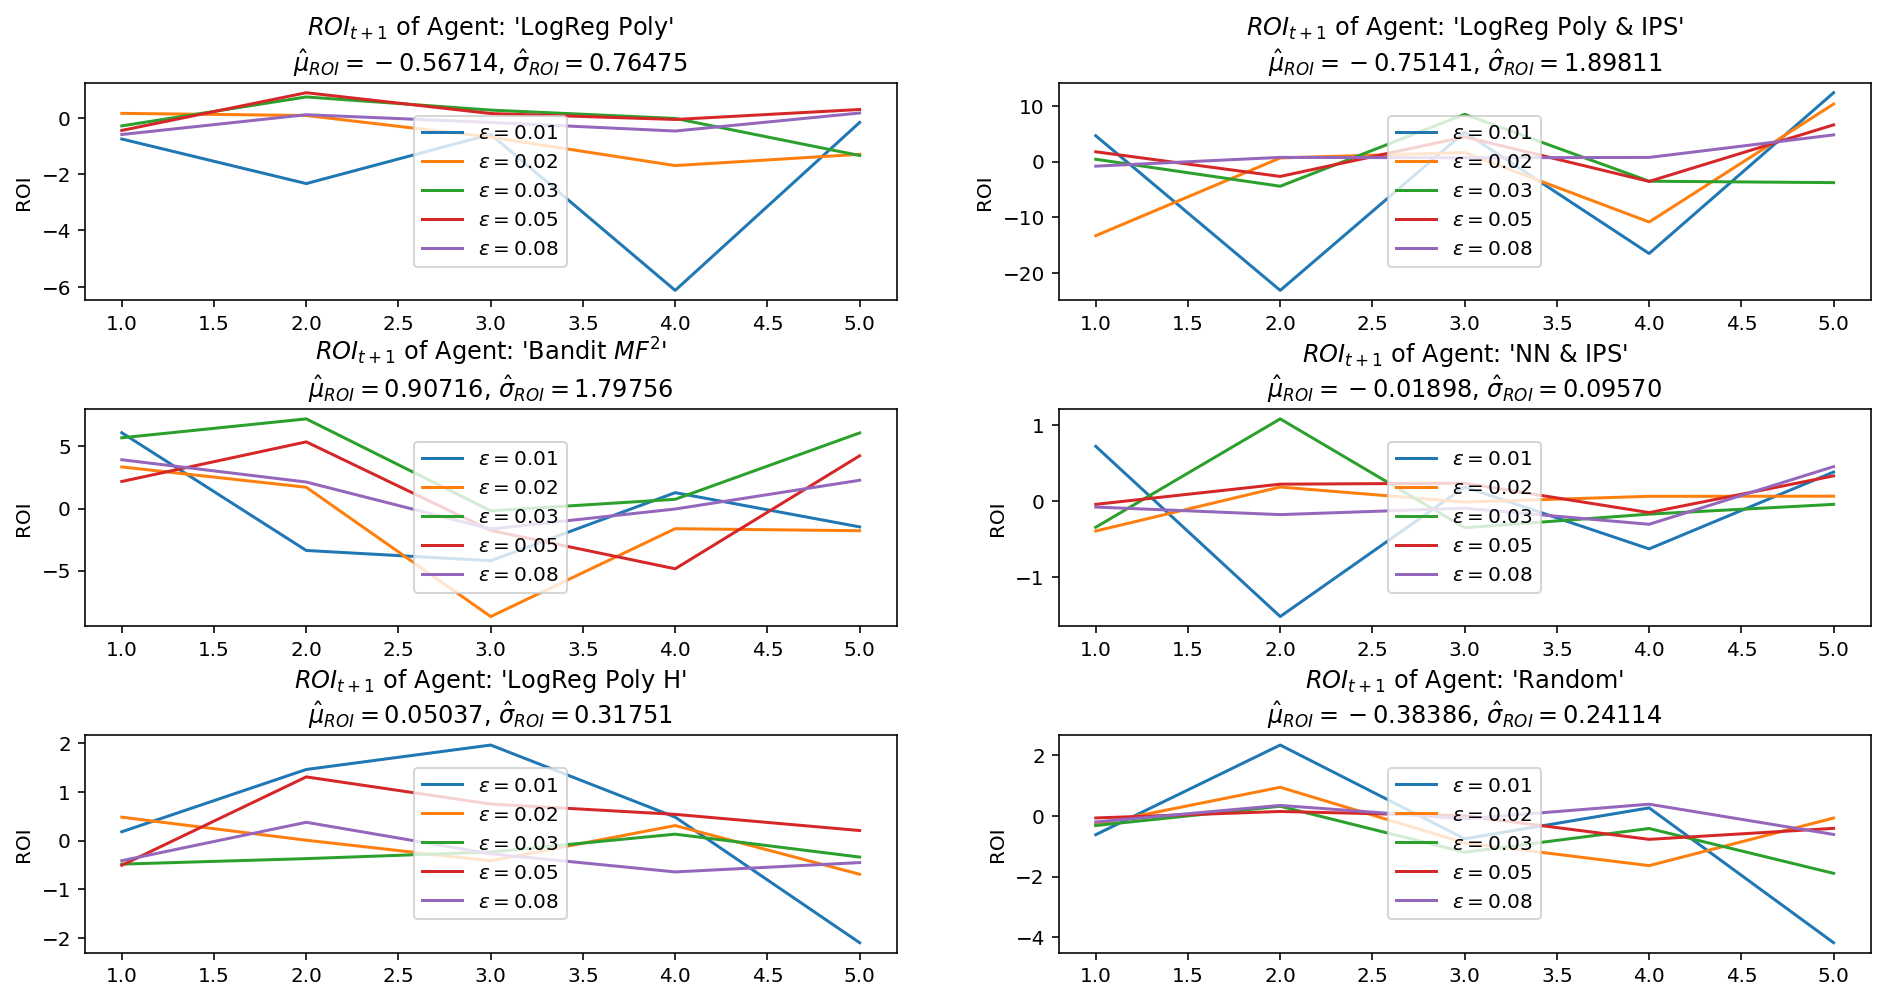

In [18]:
stats_roi_all_data = plot_roi(stats_all_data)

#### Model Retraining: All _Exploration_ Data

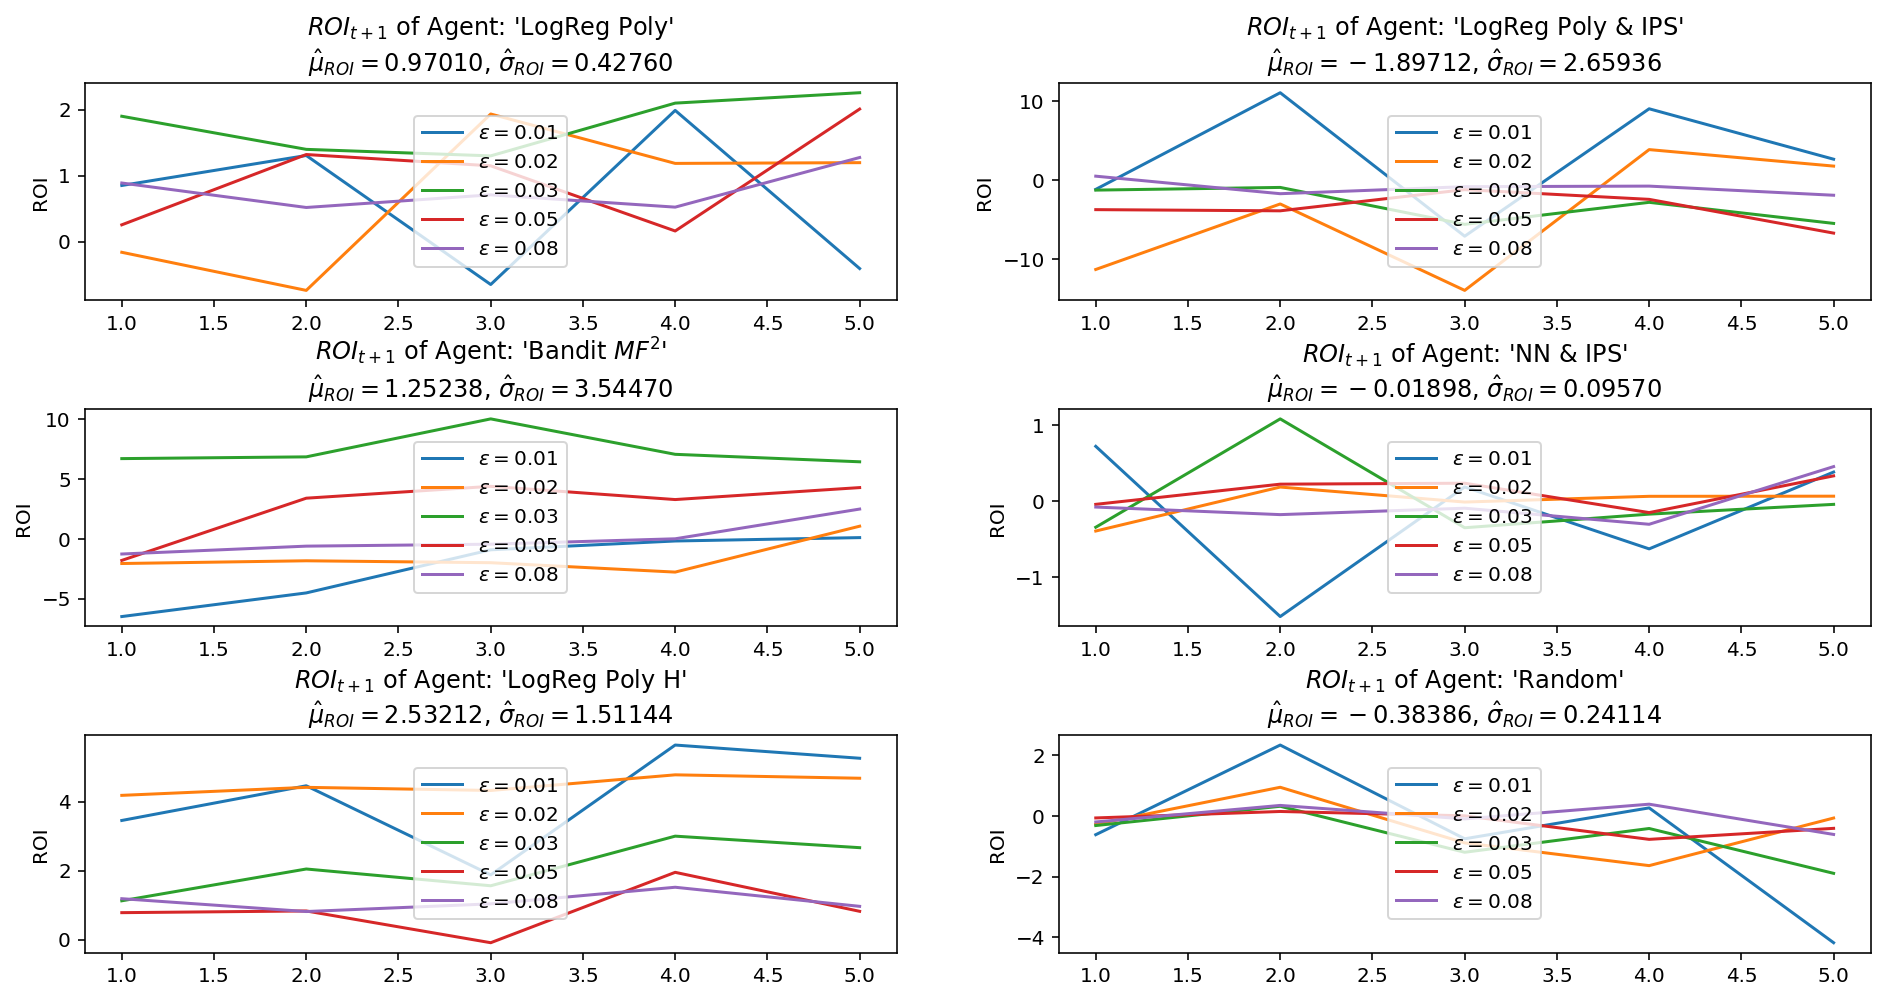

In [19]:
stats_roi_all_explorations = plot_roi(stats_all_explorations)

#### Model Retraining: the _Latest_ Set of Data

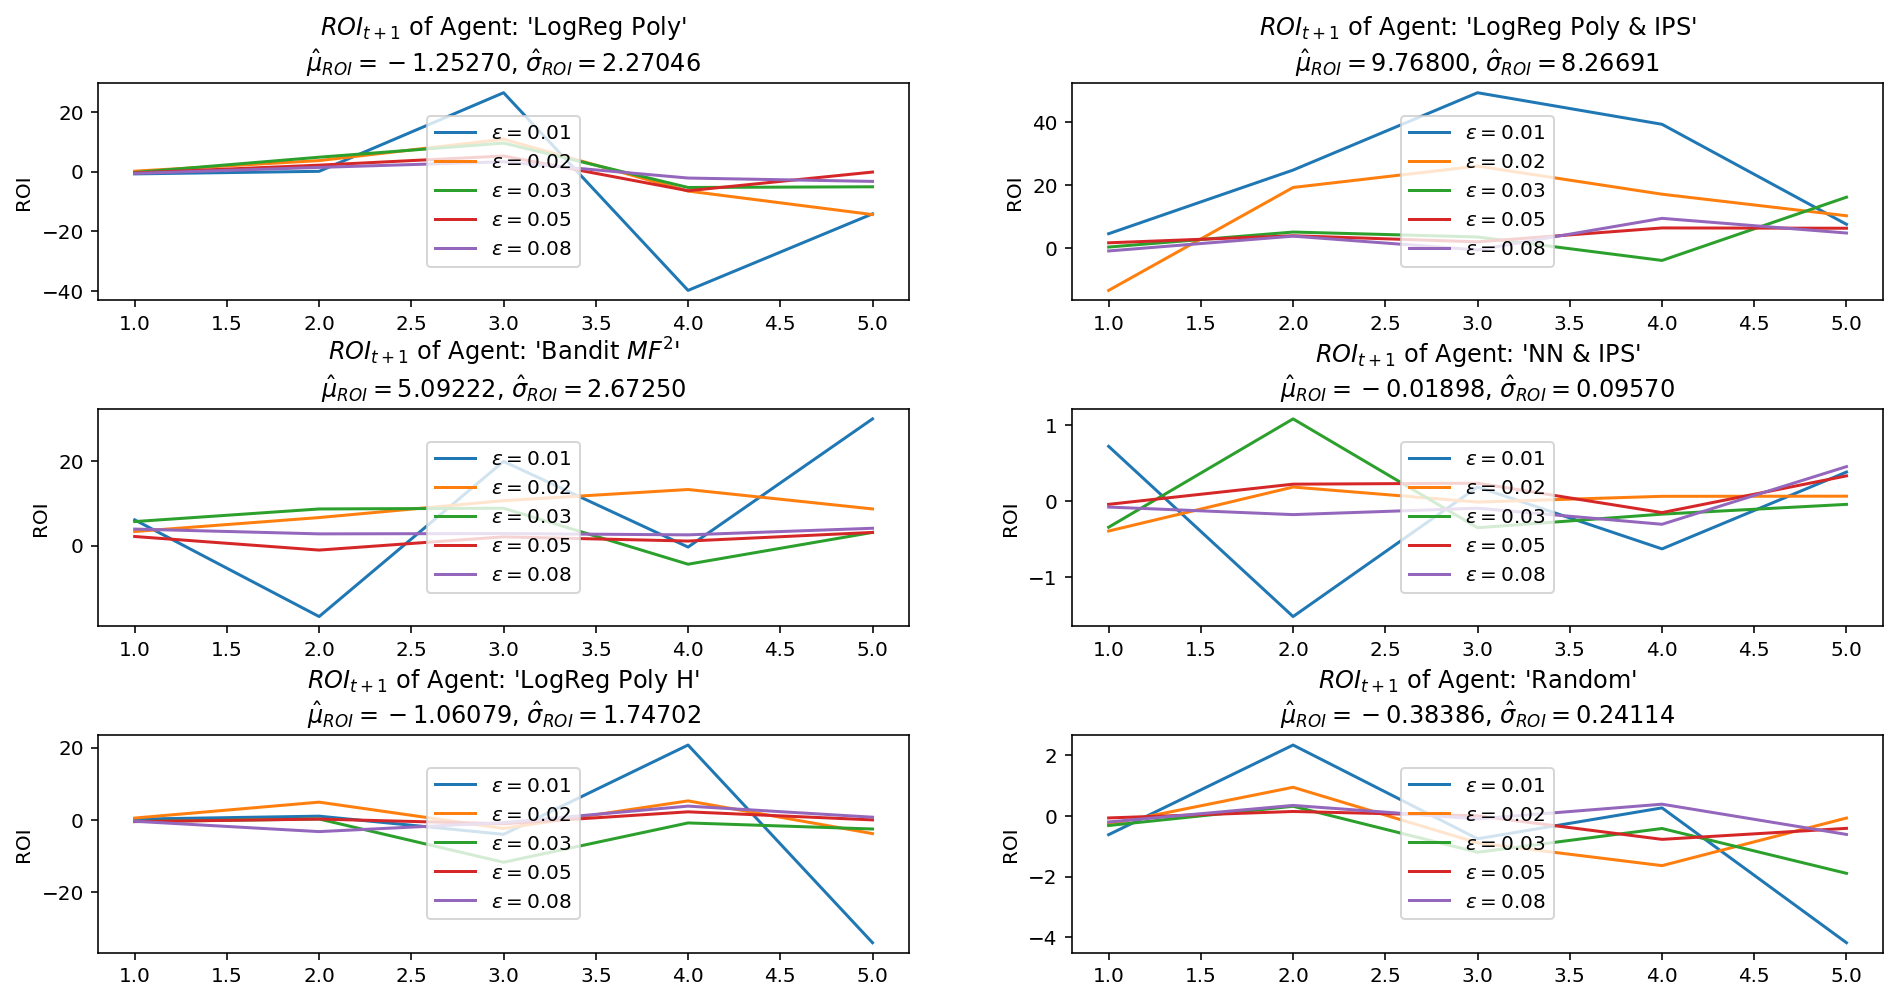

In [20]:
stats_roi_last_steps = plot_roi(stats_last_steps)

# Conclusion

In this notebook, _Epsilon-Greedy Policy Selection_ was applied to different _`Agents`_ and it was studied how different values of $\varepsilon$ influences on _Click-Through Rate_.

Besides, we tried to estimate the effectiveness of applying _Exploration_ for different models. As a measurement of _Exploration_, _Return-of-Investment_ was considered.